<a href="https://colab.research.google.com/github/shaanbarca/tokenomics-research/blob/main/Final_ico_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from matplotlib import rcParams
from pandas.io.json import json_normalize
from collections import ChainMap
import ast
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set(rc={'figure.figsize':(12,8)})
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
rcParams['figure.figsize'] = 12,8
#sns.set_theme()

# Relevant functions

In [ ]:
def descriptive_table(data):
  " Function that outputs descriptive data"

  sum_table = data.describe().round(1)
  sum_table = sum_table.T
  return sum_table

def flattened_cols(col_name):
  """
  extracts nested dict, returns df of them
  """
  dictionary_data = asset_df[col_name].to_dict()
  dist_flat = []

  for key, value in dictionary_data.items():
    dist_flat.append(value)

  dictionary_clean = []  #string dict to dict 
  for i in dist_flat:
    dictionary_clean.append(ast.literal_eval((i)))

  flattend_df = pd.DataFrame(dictionary_clean)
  return flattend_df

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    

# data cleaning

In [ ]:
# flaggin consensus
# asset_df["consensus__general_consensus_mechanism"].fillna(" ", inplace=True)
# asset_df["PROOF-OF-WORK"] = [1 if "PROOF-OF-WORK" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["DELEGATED PROOF-OF-STAKE"] = [1 if "DELEGATED PROOF-OF-STAKE" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["HYBRID POW & POS"] = [1 if "HYBRID POW & POS" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-STAKE, DAG"] = [1 if "PROOF-OF-STAKE, DAG" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["DAG"] = [1 if "DAG" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-WORK, OTHER"] = [1 if "PROOF-OF-WORK, OTHER" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["PROOF-OF-STAKE, OTHER"] = [1 if "PROOF-OF-STAKE, OTHER" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]
# asset_df["HYBRID POW & DPOS"] = [1 if "HYBRID POW & DPOS" in str(i) else 0 for i in asset_df["consensus__general_consensus_mechanism"]]

# asset_df['consensus__general_consensus_mechanism'] = asset_df['consensus__general_consensus_mechanism'].str.upper()
# asset_df['consensus__general_consensus_mechanism'] = asset_df['consensus__general_consensus_mechanism'].str.strip()
# asset_df['consensus__general_consensus_mechanism'].replace( { r"OTHER, PROOF-OF-WORK" : 'PROOF-OF-WORK, OTHER' }, inplace= True, regex = True)

#flattened_assets = flattened_assets.join(fund_df)

# Initial Data EDA

In [ ]:
asset_df = pd.read_csv('/content/super_super_final_crypto.csv')
assets_fundraise = pd.read_csv('/content/assets_fundraise.csv')

In [ ]:
descstats_assetfund = descriptive_table(assets_fundraise)
descstats_assetfund 

count          mean           std        min         25%  \
Total Raised      180.0  5.807500e+07  3.239694e+08    72355.0   4812500.0   
Total supply      203.0  9.919612e+11  9.851137e+12   212503.0  38887609.5   
Private/Pre-sale   67.0  3.662030e+09  1.871633e+10  1450000.0  37850000.0   
Public sale       103.0  1.950093e+11  1.970562e+12    30000.0  10000000.0   

                          50%          75%           max  
Total Raised       14925000.0   32211953.5  4.196874e+09  
Total supply      100000000.0  640243508.5  9.999900e+13  
Private/Pre-sale  133333334.0  725700000.0  1.498500e+11  
Public sale        47000000.0  193863734.5  1.999980e+13

Text(0.5, 1.0, 'Total raised per token (All_time)')

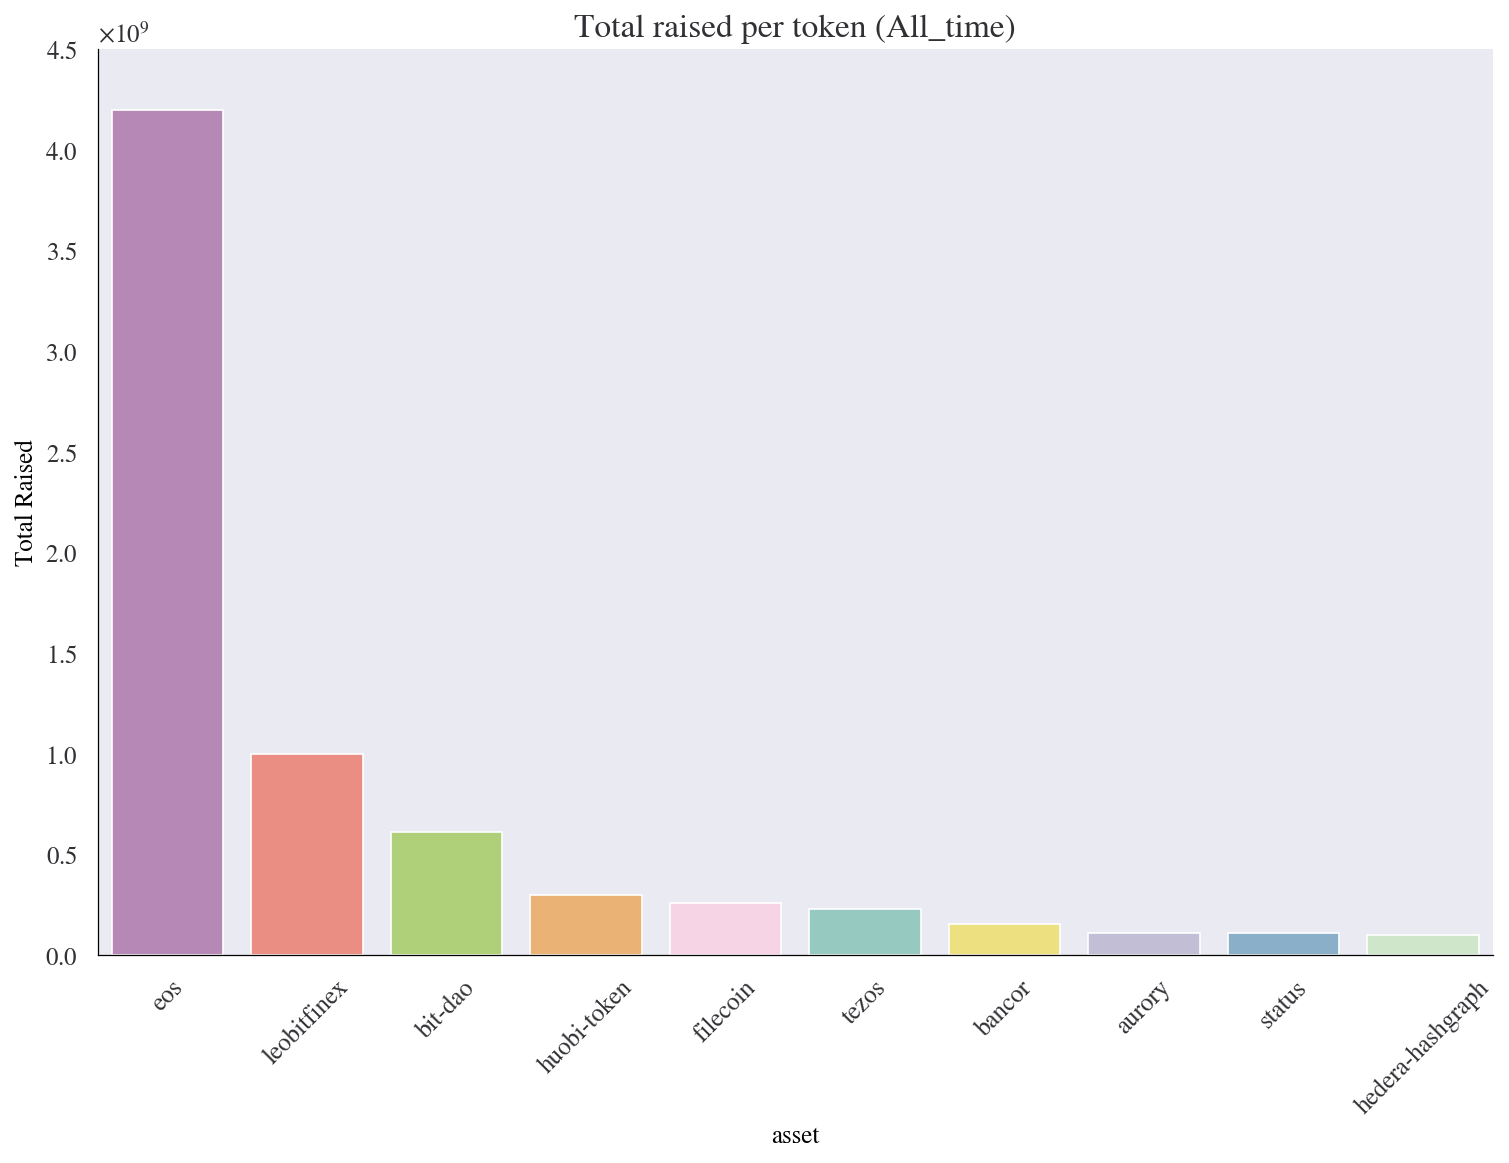

In [ ]:
# ico barplot
highest_raised = assets_fundraise.sort_values(by='Total Raised',ascending=False).head(10)
ax = sns.barplot(x="asset", y="Total Raised", data=highest_raised.head(10))
ax.set_xticklabels(labels = highest_raised.asset,rotation=45)
ax.set_title("Total raised per token (All_time)", loc="center")

In [ ]:
#types of funding
assets_fundraise['R1 type'].unique()

array(['Private ', 'ICO ', 'Private/Pre-sale ', 'IEO ', 'IDO ', nan,
       'Seed ', 'Private 2 '], dtype=object)

Text(0.5, 1.0, 'Total raised from ICO per token (r1)')

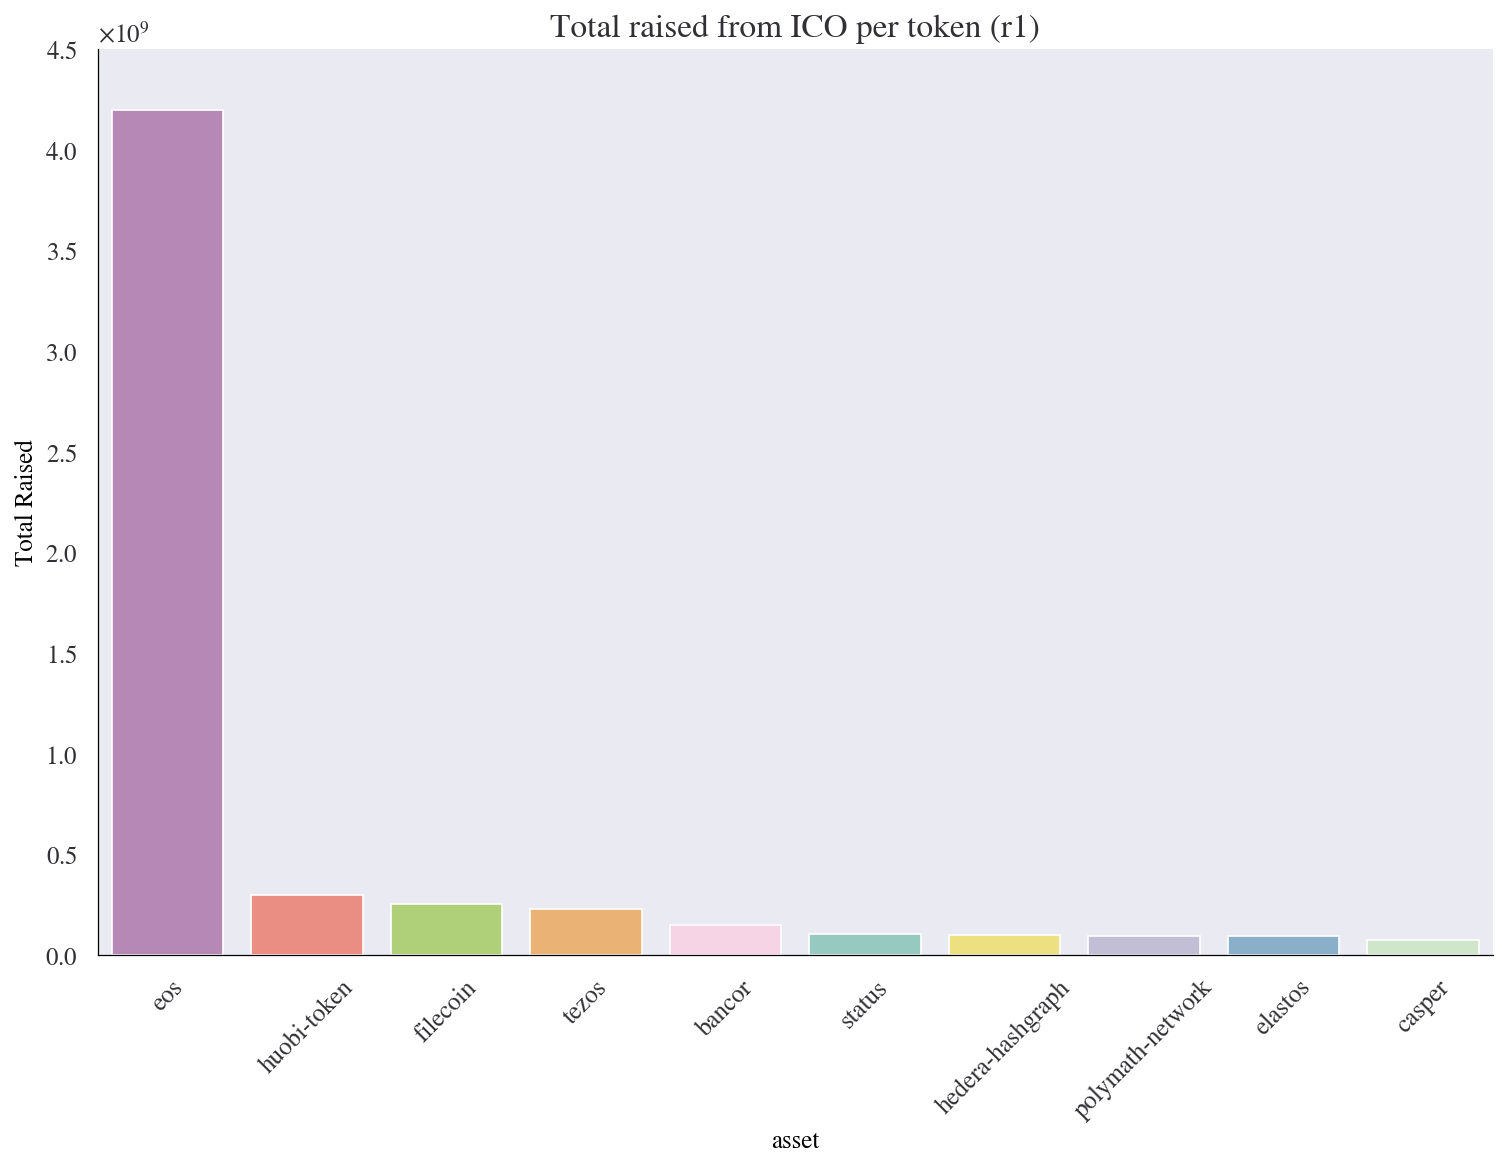

In [ ]:
#test_assets_fundraise = assets_fundraise.str.strip()
assets_fundraise['R1 type'] = assets_fundraise['R1 type'].str.strip()
highest_raised_ico_r1 = assets_fundraise[assets_fundraise['R1 type'] == "ICO"]
highest_raised_ico_r1 = highest_raised_ico_r1.sort_values(by='Total Raised',ascending=False).head(10)
ax = sns.barplot(x="asset", y="Total Raised", data=highest_raised_ico_r1.head(10))
ax.set_xticklabels(labels = highest_raised_ico_r1.asset,rotation=45)
ax.set_title("Total raised from ICO per token (r1)", loc="center")


# Mutual information score

In [ ]:
# rename col name for consistency
#df.rename(columns = {'old_col1':'new_col1', 'old_col2':'new_col2'}, inplace = True)

asset_df.rename(columns = {'name':'asset',}, inplace = True)
asset_df.head(3)

Unnamed: 0  Unnamed: 0.1     asset symbol     price_usd  price_btc  \
0           0             0   Bitcoin    BTC  34659.297687   1.000000   
1           1             1  Ethereum    ETH   2561.166777   0.073896   
2           2             2    Tether   USDT      0.999732   0.000029   

   price_eth  volume_last_24_hours  real_volume_last_24_hours  \
0   13.53262          5.425426e+09               3.156681e+09   
1    1.00000          3.789751e+09               2.286683e+09   
2    0.00039          2.759426e+08               7.351523e+07   

   volume_last_24_hours_overstatement_multiple  \
0                                     1.718712   
1                                     1.657314   
2                                     3.753543   

   percent_change_usd_last_1_hour  percent_change_btc_last_1_hour  \
0                       -0.337203                        0.000000   
1                       -0.329556                        0.007674   
2                       -0.006887                        0.331434   

   percent_change_eth_last_1_hour  percent_change_usd_last_24_hours  \
0                       -0.007673                         -3.731989   
1                        0.000000                         -4.654129   
2                        0.323735                          0.040212   

   percent_change_btc_last_24_hours  percent_change_eth_last_24_hours  \
0                          0.000019                          0.944218   
1                         -0.957869                         -0.022714   
2                          3.918456                          4.899653   

   ohlcv_last_1_hour__open  ohlcv_last_1_hour__high  ohlcv_last_1_hour__low  \
0             34787.770651             34788.151317            34775.176824   
1              2570.150421              2570.236027             2569.442358   
2                 0.999801                 0.999801                0.999320   

   ohlcv_last_1_hour__close  ohlcv_last_1_hour__volume  \
0              34776.565475              470471.694477   
1               2569.635151              307747.079605   
2                  0.999801               10849.882560   

   ohlcv_last_24_hour__open  ohlcv_last_24_hour__high  \
0              35991.706193              36020.920583   
1               2684.892543               2688.760494   
2                  0.999666                  0.999879   

   ohlcv_last_24_hour__low  ohlcv_last_24_hour__close  \
0             35939.571621               36002.922914   
1              2678.199533                2686.185302   
2                 0.999093                   0.999330   

   ohlcv_last_24_hour__volume         last_trade_at  rank  \
0                2.874658e+07  2022-05-08T12:33:36Z     1   
1                1.705275e+07  2022-05-08T12:33:36Z     2   
2                4.525019e+06  2022-05-08T12:33:36Z     3   

   marketcap_dominance_percent  current_marketcap_usd  y_2050_marketcap_usd  \
0                    41.981287           6.596436e+11          7.273559e+11   
1                    19.674506           3.091416e+11          3.461890e+11   
2                     5.296192           8.321800e+10                   NaN   

   y_plus10_marketcap_usd  liquid_marketcap_usd  \
0            7.168749e+11          6.599624e+11   
1            3.146614e+11          2.981072e+11   
2                     NaN                   NaN   

   volume_turnover_last_24_hours_percent  realized_marketcap_usd  \
0                               0.478182            4.645463e+11   
1                               0.767166            2.233168e+11   
2                                    NaN            1.335289e+09   

   outstanding_marketcap_usd        y_2050      y_plus10        liquid  \
0               6.758530e+11  2.098634e+07  2.068393e+07  1.904184e+07   
1               3.121780e+11  1.351356e+08  1.228288e+08  1.163668e+08   
2               1.334632e+09           NaN           NaN           NaN   

    circulating  y_2050_issued_percent  annual_i

In [ ]:
# check missing values as there are alot before we run mi score
missing_values_count = asset_df.isnull().sum().sort_values(ascending=False)
missing_values_count.head(10)

lines_added_last_3_months                  500
lines_deleted_last_1_year                  500
roi_since_sale_btc_percent                 500
commits_last_1_year                        500
lines_added_last_1_year                    500
roi_since_sale_usd_percent                 500
sale_end_date                              500
sale_start_date                            500
native_treasury__treasury_usage_details    500
ohlcv_last_1_hour                          500
dtype: int64

In [ ]:
assets_fundraise.isnull().sum().sort_values(ascending=False).tail(10)

Public sale     100
R1 Raise         48
Total Raised     23
R1 Price         19
R1 ROI           19
R1 ATH ROI       19
R1 date          14
R1 type          13
Total supply      0
asset             0
dtype: int64

In [ ]:
total_cells = np.product(asset_df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

52.00733944954128


## combine dataset asset fundraise with asset as there are too many missing values

In [ ]:
# ensuring they all have same name
assets_fundraise['asset'] = assets_fundraise['asset'].str.lower()
asset_df['asset'] = asset_df['asset'].str.lower()

assets_fundraise['asset'] = assets_fundraise['asset'].str.strip()
asset_df['asset'] = asset_df['asset'].str.strip()

In [ ]:
asset_df.head(3)

Unnamed: 0  Unnamed: 0.1     asset symbol     price_usd  price_btc  \
0           0             0   bitcoin    BTC  34659.297687   1.000000   
1           1             1  ethereum    ETH   2561.166777   0.073896   
2           2             2    tether   USDT      0.999732   0.000029   

   price_eth  volume_last_24_hours  real_volume_last_24_hours  \
0   13.53262          5.425426e+09               3.156681e+09   
1    1.00000          3.789751e+09               2.286683e+09   
2    0.00039          2.759426e+08               7.351523e+07   

   volume_last_24_hours_overstatement_multiple  \
0                                     1.718712   
1                                     1.657314   
2                                     3.753543   

   percent_change_usd_last_1_hour  percent_change_btc_last_1_hour  \
0                       -0.337203                        0.000000   
1                       -0.329556                        0.007674   
2                       -0.006887                        0.331434   

   percent_change_eth_last_1_hour  percent_change_usd_last_24_hours  \
0                       -0.007673                         -3.731989   
1                        0.000000                         -4.654129   
2                        0.323735                          0.040212   

   percent_change_btc_last_24_hours  percent_change_eth_last_24_hours  \
0                          0.000019                          0.944218   
1                         -0.957869                         -0.022714   
2                          3.918456                          4.899653   

   ohlcv_last_1_hour__open  ohlcv_last_1_hour__high  ohlcv_last_1_hour__low  \
0             34787.770651             34788.151317            34775.176824   
1              2570.150421              2570.236027             2569.442358   
2                 0.999801                 0.999801                0.999320   

   ohlcv_last_1_hour__close  ohlcv_last_1_hour__volume  \
0              34776.565475              470471.694477   
1               2569.635151              307747.079605   
2                  0.999801               10849.882560   

   ohlcv_last_24_hour__open  ohlcv_last_24_hour__high  \
0              35991.706193              36020.920583   
1               2684.892543               2688.760494   
2                  0.999666                  0.999879   

   ohlcv_last_24_hour__low  ohlcv_last_24_hour__close  \
0             35939.571621               36002.922914   
1              2678.199533                2686.185302   
2                 0.999093                   0.999330   

   ohlcv_last_24_hour__volume         last_trade_at  rank  \
0                2.874658e+07  2022-05-08T12:33:36Z     1   
1                1.705275e+07  2022-05-08T12:33:36Z     2   
2                4.525019e+06  2022-05-08T12:33:36Z     3   

   marketcap_dominance_percent  current_marketcap_usd  y_2050_marketcap_usd  \
0                    41.981287           6.596436e+11          7.273559e+11   
1                    19.674506           3.091416e+11          3.461890e+11   
2                     5.296192           8.321800e+10                   NaN   

   y_plus10_marketcap_usd  liquid_marketcap_usd  \
0            7.168749e+11          6.599624e+11   
1            3.146614e+11          2.981072e+11   
2                     NaN                   NaN   

   volume_turnover_last_24_hours_percent  realized_marketcap_usd  \
0                               0.478182            4.645463e+11   
1                               0.767166            2.233168e+11   
2                                    NaN            1.335289e+09   

   outstanding_marketcap_usd        y_2050      y_plus10        liquid  \
0               6.758530e+11  2.098634e+07  2.068393e+07  1.904184e+07   
1               3.121780e+11  1.351356e+08  1.228288e+08  1.163668e+08   
2               1.334632e+09           NaN           NaN           NaN   

    circulating  y_2050_issued_percent  annual_i

# Merging Dataframes

In [ ]:
combined_df = pd.merge(asset_df,assets_fundraise,on='asset',how='outer')
combined_df.head(3)

Unnamed: 0  Unnamed: 0.1     asset symbol     price_usd  price_btc  \
0         0.0           0.0   bitcoin    BTC  34659.297687   1.000000   
1         1.0           1.0  ethereum    ETH   2561.166777   0.073896   
2         2.0           2.0    tether   USDT      0.999732   0.000029   

   price_eth  volume_last_24_hours  real_volume_last_24_hours  \
0   13.53262          5.425426e+09               3.156681e+09   
1    1.00000          3.789751e+09               2.286683e+09   
2    0.00039          2.759426e+08               7.351523e+07   

   volume_last_24_hours_overstatement_multiple  \
0                                     1.718712   
1                                     1.657314   
2                                     3.753543   

   percent_change_usd_last_1_hour  percent_change_btc_last_1_hour  \
0                       -0.337203                        0.000000   
1                       -0.329556                        0.007674   
2                       -0.006887                        0.331434   

   percent_change_eth_last_1_hour  percent_change_usd_last_24_hours  \
0                       -0.007673                         -3.731989   
1                        0.000000                         -4.654129   
2                        0.323735                          0.040212   

   percent_change_btc_last_24_hours  percent_change_eth_last_24_hours  \
0                          0.000019                          0.944218   
1                         -0.957869                         -0.022714   
2                          3.918456                          4.899653   

   ohlcv_last_1_hour__open  ohlcv_last_1_hour__high  ohlcv_last_1_hour__low  \
0             34787.770651             34788.151317            34775.176824   
1              2570.150421              2570.236027             2569.442358   
2                 0.999801                 0.999801                0.999320   

   ohlcv_last_1_hour__close  ohlcv_last_1_hour__volume  \
0              34776.565475              470471.694477   
1               2569.635151              307747.079605   
2                  0.999801               10849.882560   

   ohlcv_last_24_hour__open  ohlcv_last_24_hour__high  \
0              35991.706193              36020.920583   
1               2684.892543               2688.760494   
2                  0.999666                  0.999879   

   ohlcv_last_24_hour__low  ohlcv_last_24_hour__close  \
0             35939.571621               36002.922914   
1              2678.199533                2686.185302   
2                 0.999093                   0.999330   

   ohlcv_last_24_hour__volume         last_trade_at  rank  \
0                2.874658e+07  2022-05-08T12:33:36Z   1.0   
1                1.705275e+07  2022-05-08T12:33:36Z   2.0   
2                4.525019e+06  2022-05-08T12:33:36Z   3.0   

   marketcap_dominance_percent  current_marketcap_usd  y_2050_marketcap_usd  \
0                    41.981287           6.596436e+11          7.273559e+11   
1                    19.674506           3.091416e+11          3.461890e+11   
2                     5.296192           8.321800e+10                   NaN   

   y_plus10_marketcap_usd  liquid_marketcap_usd  \
0            7.168749e+11          6.599624e+11   
1            3.146614e+11          2.981072e+11   
2                     NaN                   NaN   

   volume_turnover_last_24_hours_percent  realized_marketcap_usd  \
0                               0.478182            4.645463e+11   
1                               0.767166            2.233168e+11   
2                                    NaN            1.335289e+09   

   outstanding_marketcap_usd        y_2050      y_plus10        liquid  \
0               6.758530e+11  2.098634e+07  2.068393e+07  1.904184e+07   
1               3.121780e+11  1.351356e+08  1.228288e+08  1.163668e+08   
2               1.334632e+09           NaN           NaN           NaN   

    circulating  y_2050_issued_percent  annual_i

In [ ]:
combined_df['start_year'] = np.where(combined_df['start_year'].isnull() == True, combined_df['initial_distribution__genesis_block_year'], combined_df['start_year'])

In [ ]:
combined_df = combined_df[combined_df['start_year'].notna()]

In [ ]:
#combined_df.to_csv('super_super_super_final.csv')

In [ ]:
#combined_df.isnull().sum().sort_values(ascending=False).head(1000)

In [ ]:
#combined_df.isnull().sum().sort_values(ascending=False)

In [ ]:
combined_df = combined_df.loc[:, combined_df.isin([' ','NULL',np.nan]).mean() < 1]

In [ ]:
combined_df = combined_df.drop(columns=['Unnamed: 0.1','Unnamed: 0'])

In [ ]:
combined_df.shape

(209, 249)

## Impute missing data

In [ ]:
#fill 0 for certain cols
combined_df['general__launch_style'] = combined_df['general__launch_style'].fillna('launch_not_specified') # only 52 is missing so we can impute null value 'not specified'
combined_df['supply__general_emission_type'] = combined_df['supply__general_emission_type'].fillna('emission_not_specified') # 52 missing again, replace na with not specified
combined_df['supply__precise_emission_type'] = combined_df['supply__precise_emission_type'].fillna('precise_emission_not_specified')
combined_df['supply__is_capped_supply'] = combined_df['supply__is_capped_supply'].fillna('supply_cap_not_specified')
combined_df[['allocated_to_organization_or_founders_percentage','allocated_to_investors_percentage']] = combined_df[['allocated_to_organization_or_founders_percentage','allocated_to_investors_percentage']].fillna(0)
combined_df['R1 type'] = combined_df['R1 type'].fillna('R1_type_not_specied')

In [ ]:
combined_df['consensus__general_consensus_mechanism'] = combined_df['consensus__general_consensus_mechanism'].replace(r'^\s*$', np.NaN, regex=True)
combined_df['consensus__general_consensus_mechanism'] = combined_df['consensus__general_consensus_mechanism'].fillna('Consensus_mechanism_notspecified')

In [ ]:
dropped_cols = ['outstanding_marketcap_usd','ohlcv_last_24_hour__volume','y_plus10_marketcap_usd','liquid_marketcap_usd','token__token_address',
                'last_trade_at','volume_last_24_hours_overstatement_multiple','price_eth','price_btc','price_usd','real_volume_last_24_hours',
                'volume_last_24_hours','symbol','token__token_usage','token__token_usage_details','general__launch_details',
                'fundraising__sales_rounds','fundraising__sales_documents','fundraising__sales_treasury_accounts','fundraising__treasury_policies','fundraising__projected_use_of_sales_proceeds',
                'initial_distribution__token_distribution_date',
                'initial_distribution__genesis_block_date','supply__supply_curve_details','consensus__consensus_details','consensus__mining_algorithm',
                'consensus__next_halving_date','governance_details','onchain_governance__onchain_governance_type',
                'onchain_governance__onchain_governance_details','title','start_date','type','details','end_date',
                'restricted_jurisdictions','R1 ROI','R2 ROI','R3 ROI','R4 ROI','R5 ROI','R1 ATH ROI','R2 ATH ROI','R3 ATH ROI','R4 ATH ROI','R5 ATH ROI','rank','marketcap_dominance_percent']

# Check missing values in combined_df

potentially useful columns

* general__launch_style
* initial_distribution__initial_supply
* supply__general_emission_type
* supply__precise_emission_type
* supply__is_capped_supply

In [ ]:
cleaned_combined_df = combined_df.drop(dropped_cols,axis=1)

In [ ]:
cleaned_assets = cleaned_combined_df.dropna(axis=1) # drop all na

In [ ]:
X = cleaned_assets.copy()
X = X.drop(columns=['asset'])
y = X.pop('current_marketcap_usd')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [ ]:
mi_scores.head(10)

supply__general_emission_type                       0.165179
general__launch_style                               0.163969
supply__precise_emission_type                       0.139193
token__token_type                                   0.132227
native                                              0.079774
erc20                                               0.076185
allocated_to_organization_or_founders_percentage    0.069804
R1 type                                             0.067161
consensus__general_consensus_mechanism              0.058993
allocated_to_investors_percentage                   0.038826
Name: MI Scores, dtype: float64

# Mutual Information

When dealing with data with a large amount of features it is beneficial identify which are the potentially key features. To do so, we calculate the mutual information scores. What is measures is how much information is lost to predict/classify our target variable when a feature is removed. There are advantages of using mutual information over pearson correlation as it is not limited to identifying just linear relationships. 

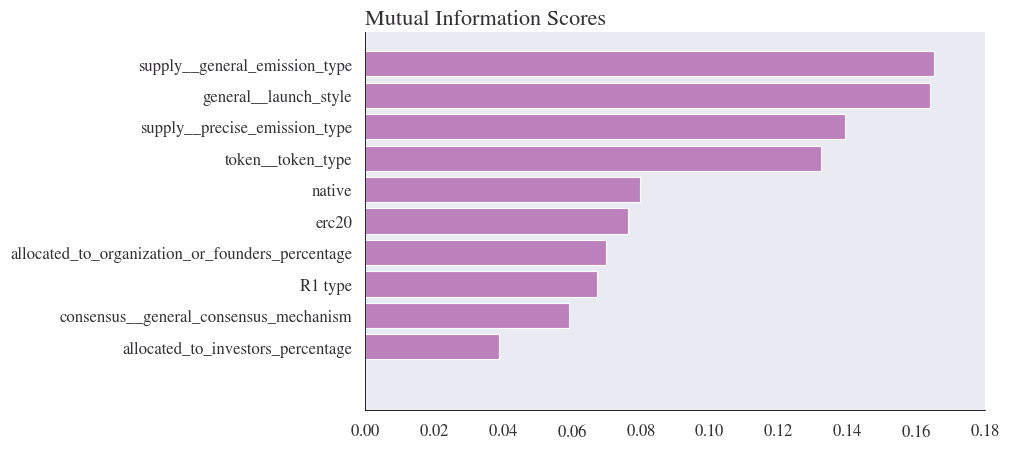

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

# Descriptive statistics

We do some descriptive statistics to check the data we are dealing with. In this particular case, we will be using it to categorize the market cap of tokens into seperate categories. Using percentiles, we can bin the market cap of tokens into low, medium, high and very high

In [ ]:
descriptive_table(cleaned_assets).head(5)

count          mean           std        min  \
current_marketcap_usd           209.0  6.101972e+09  5.044152e+10  3118475.5   
circulating                     209.0  5.546765e+09  2.005907e+10    91121.3   
percent_change_last_1_week      209.0 -8.700000e+00  8.100000e+00      -32.2   
percent_change_btc_last_1_week  209.0  1.000000e+00  8.900000e+00      -25.0   
percent_change_eth_last_1_week  209.0  2.000000e-01  8.900000e+00      -25.5   

                                       25%          50%           75%  \
current_marketcap_usd           27338239.1  120201552.5  5.507598e+08   
circulating                     66588888.0  288094211.0  1.165282e+09   
percent_change_last_1_week           -12.1         -9.4 -5.600000e+00   
percent_change_btc_last_1_week        -2.8          0.2  4.400000e+00   
percent_change_eth_last_1_week        -3.5         -0.5  3.700000e+00   

                                         max  
current_marketcap_usd           6.596436e+11  
circulating                     1.840668e+11  
percent_change_last_1_week      2.720000e+01  
percent_change_btc_last_1_week  4.060000e+01  
percent_change_eth_last_1_week  3.960000e+01

## categorizing performance

In [ ]:
marketcap_conditions = [
    (cleaned_assets['current_marketcap_usd'] < 27338239.1),
    (cleaned_assets['current_marketcap_usd'] >= 27338239.1) & (cleaned_assets['current_marketcap_usd'] < 120201552.5),
    (cleaned_assets['current_marketcap_usd'] >= 120201552.5) & (cleaned_assets['current_marketcap_usd'] < 5.507598e+08),
    (cleaned_assets['current_marketcap_usd'] >= 5.507598e+08)
]
marketcap_categories = ['low', 'medium', 'high','very high']
cleaned_assets['marketcap_categories'] = np.select(marketcap_conditions, marketcap_categories)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Median marketcap per year

One feature that we create is the Median marketcap of coins in that year. The feature was creates as we suspect that launching a coin in the bull or bear market can make a signicant impact a coin's future marketcap

In [ ]:
# get average marketcap per year
cleaned_assets["MedianMarketcap_yearly"] = (
    cleaned_assets.groupby("start_year")
    ["current_marketcap_usd"]
    .transform("median")
) 

cleaned_assets[["start_year", "current_marketcap_usd", "MedianMarketcap_yearly"]].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


start_year  current_marketcap_usd  MedianMarketcap_yearly
0       2009.0           6.596436e+11            1.342765e+09
1       2014.0           3.091416e+11            5.861808e+08
3       2017.0           5.818232e+10            1.124840e+08
6       2020.0           2.632893e+10            2.037711e+08
7       2017.0           2.513058e+10            1.124840e+08
8       2019.0           2.133582e+10            5.030024e+08
11      2013.0           1.666530e+10            5.090272e+07
12      2020.0           1.444531e+10            2.037711e+08
13      2020.0           1.334395e+10            2.037711e+08
16      2018.0           8.496035e+09            5.337451e+07

In [ ]:
cleaned_assets.head()

asset  current_marketcap_usd   circulating  percent_change_last_1_week  \
0   bitcoin           6.596436e+11  1.903264e+07                   -9.569280   
1  ethereum           3.091416e+11  1.206741e+08                   -8.935813   
3       bnb           5.818232e+10  1.632770e+08                   -8.226820   
6    solana           2.632893e+10  3.346929e+08                  -11.688968   
7   cardano           2.513058e+10  3.382026e+10                   -5.503159   

   percent_change_btc_last_1_week  percent_change_eth_last_1_week  \
0                        0.000000                       -0.700324   
1                        0.704918                        0.000000   
3                        1.488970                        0.773797   
6                       -2.339706                       -3.027899   
7                        4.500979                        3.764581   

   percent_change_month_to_date  percent_change_quarter_to_date  \
0                     -9.569280                      -24.850741   
1                     -8.935813                      -25.565467   
3                     -8.226820                      -20.096473   
6                    -11.688968                      -41.131020   
7                     -5.503159                      -35.993120   

   percent_change_year_to_date  sharpe_ratios__last_30_days  \
0                   -27.116804                    -3.751188   
1                   -31.695333                    -3.073505   
3                   -32.159224                    -2.236757   
6                   -55.785941                    -4.076844   
7                   -45.931638                    -3.228148   

   volatility_stats__volatility_last_30_days token__token_type  \
0                                   0.543354            Native   
1                                   0.584664            Native   
3                                   0.563889    Native, ERC-20   
6                                   0.856930            Native   
7                                   0.971809            Native   

    general__launch_style supply__general_emission_type  \
0             Fair Launch                  Inflationary   
1               Crowdsale                  Inflationary   
3               Crowdsale                  Deflationary   
6  Auctions, Private Sale                  Inflationary   
7               Crowdsale                  Inflationary   

  supply__precise_emission_type supply__is_capped_supply  \
0           Decreasing Issuance                     True   
1                Fixed Issuance                    False   
3         Non-programmatic burn                     True   
6     Decreasing Inflation rate                    False   
7           Decreasing Issuance                     True   

  consensus__general_consensus_mechanism  PROOF-OF-WORK  \
0                          PROOF-OF-WORK            1.0   
1                          PROOF-OF-WORK            1.0   
3               DELEGATED PROOF-OF-STAKE            0.0   
6                         PROOF-OF-STAKE            0.0   
7                         PROOF-OF-STAKE            0.0   

   DELEGATED PROOF-OF-STAKE  HYBRID POW & POS  PROOF-OF-STAKE, DAG  DAG  \
0                       0.0               0.0                  0.0  0.0   
1                       0.0               0.0                  0.0  0.0   
3                       1.0               0.0                  0.0  0.0   
6                       0.0               0.0                  0.0  0.0   
7                       0.0               0.0                  0.0  0.0   

   PROOF-OF-WORK, OTHER  PROOF-OF-STAKE, OTHER  HYBRID POW & DPOS  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
3                   0.0                    0.0                0.0   
6                   0.0                    0.0                0.0   
7                   0.0                    0.0                0.

In [ ]:
cleaned_assets.shape

(209, 48)

In [ ]:
categorized_df = cleaned_assets.drop(columns=['current_marketcap_usd','asset'])
categorized_df.head(3)

circulating  percent_change_last_1_week  percent_change_btc_last_1_week  \
0  1.903264e+07                   -9.569280                        0.000000   
1  1.206741e+08                   -8.935813                        0.704918   
3  1.632770e+08                   -8.226820                        1.488970   

   percent_change_eth_last_1_week  percent_change_month_to_date  \
0                       -0.700324                     -9.569280   
1                        0.000000                     -8.935813   
3                        0.773797                     -8.226820   

   percent_change_quarter_to_date  percent_change_year_to_date  \
0                      -24.850741                   -27.116804   
1                      -25.565467                   -31.695333   
3                      -20.096473                   -32.159224   

   sharpe_ratios__last_30_days  volatility_stats__volatility_last_30_days  \
0                    -3.751188                                   0.543354   
1                    -3.073505                                   0.584664   
3                    -2.236757                                   0.563889   

  token__token_type general__launch_style supply__general_emission_type  \
0            Native           Fair Launch                  Inflationary   
1            Native             Crowdsale                  Inflationary   
3    Native, ERC-20             Crowdsale                  Deflationary   

  supply__precise_emission_type supply__is_capped_supply  \
0           Decreasing Issuance                     True   
1                Fixed Issuance                    False   
3         Non-programmatic burn                     True   

  consensus__general_consensus_mechanism  PROOF-OF-WORK  \
0                          PROOF-OF-WORK            1.0   
1                          PROOF-OF-WORK            1.0   
3               DELEGATED PROOF-OF-STAKE            0.0   

   DELEGATED PROOF-OF-STAKE  HYBRID POW & POS  PROOF-OF-STAKE, DAG  DAG  \
0                       0.0               0.0                  0.0  0.0   
1                       0.0               0.0                  0.0  0.0   
3                       1.0               0.0                  0.0  0.0   

   PROOF-OF-WORK, OTHER  PROOF-OF-STAKE, OTHER  HYBRID POW & DPOS  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
3                   0.0                    0.0                0.0   

   allocated_to_investors_percentage  \
0                               0.00   
1                              83.47   
3                              50.00   

   allocated_to_organization_or_founders_percentage  erc20  native  omni  \
0                                              0.00    0.0     1.0   0.0   
1                                             16.53    0.0     1.0   0.0   
3                                             50.00    1.0     1.0   0.0   

   trc20  trc10  bep2  bep20  erc777  ardor  spl  eosio  usage__payments  \
0    0.0    0.0   0.0    0.0     0.0    0.0  0.0    0.0              1.0   
1    0.0    0.0   0.0    0.0     0.0    0.0  0.0    0.0              1.0   
3    0.0    0.0   0.0    0.0     0.0    0.0  0.0    0.0              0.0   

   usage__work  usage__access  usage__discount  usage__vote  usage__dividends  \
0          0.0            0.0              0.0          0.0               0.0   
1          1.0            0.0              0.0          0.0               0.0   
3          0.0            1.0              1.0          1.0               0.0   

   start_year              R1 type marketcap_categories  \
0      2009.0  R1_type_not_specied            very high   
1      2014.0  R1_type_not_specied            very high   
3      2017.0  R1_type_not_specied            very high   

   MedianMarketcap_yearly  
0            1.342765e+09  
1            5.861808e+08  
3            1.124840e+08

# Dropping more columns that potentially can leak data

In [ ]:
drop_more_cols = ['percent_change_last_1_week','percent_change_btc_last_1_week','percent_change_eth_last_1_week','volatility_stats__volatility_last_30_days','sharpe_ratios__last_30_days','percent_change_year_to_date','percent_change_quarter_to_date','percent_change_month_to_date']
categorized_df = categorized_df.drop(drop_more_cols,axis=1)

retry mutual info

In [ ]:
X = categorized_df.copy()
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
y = X.pop('marketcap_categories')
discrete_features = X.dtypes == int

In [ ]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

In [ ]:
mi_scores.head(14)

general__launch_style                               0.207579
supply__precise_emission_type                       0.143116
token__token_type                                   0.119946
allocated_to_organization_or_founders_percentage    0.109945
erc777                                              0.078499
R1 type                                             0.064327
consensus__general_consensus_mechanism              0.060725
ardor                                               0.059312
circulating                                         0.049601
MedianMarketcap_yearly                              0.043889
DAG                                                 0.040645
usage__discount                                     0.038784
trc10                                               0.037202
eosio                                               0.036175
Name: MI Scores, dtype: float64

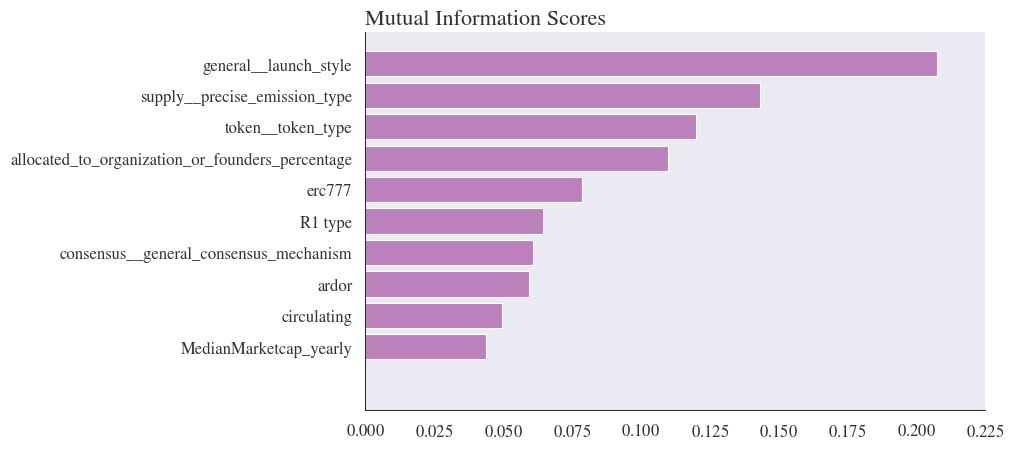

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

When we calculate Mutual information(MI), we see that the model has narrowed down these few key features as the most important to determining a coins future market cap. One of the limitations of MI is that it can only identify univariate relationships. Meaning, certain variables that might not be helpful on its own but are useful when combined with other variables is not captured. 

We will do further EDA on the features that our model has identified

# EDA

In [ ]:
cleaned_assets['logged_marketcap'] = np.log(cleaned_assets["current_marketcap_usd"]) # scales better

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0.98, 'Marketcap of coins by token type')

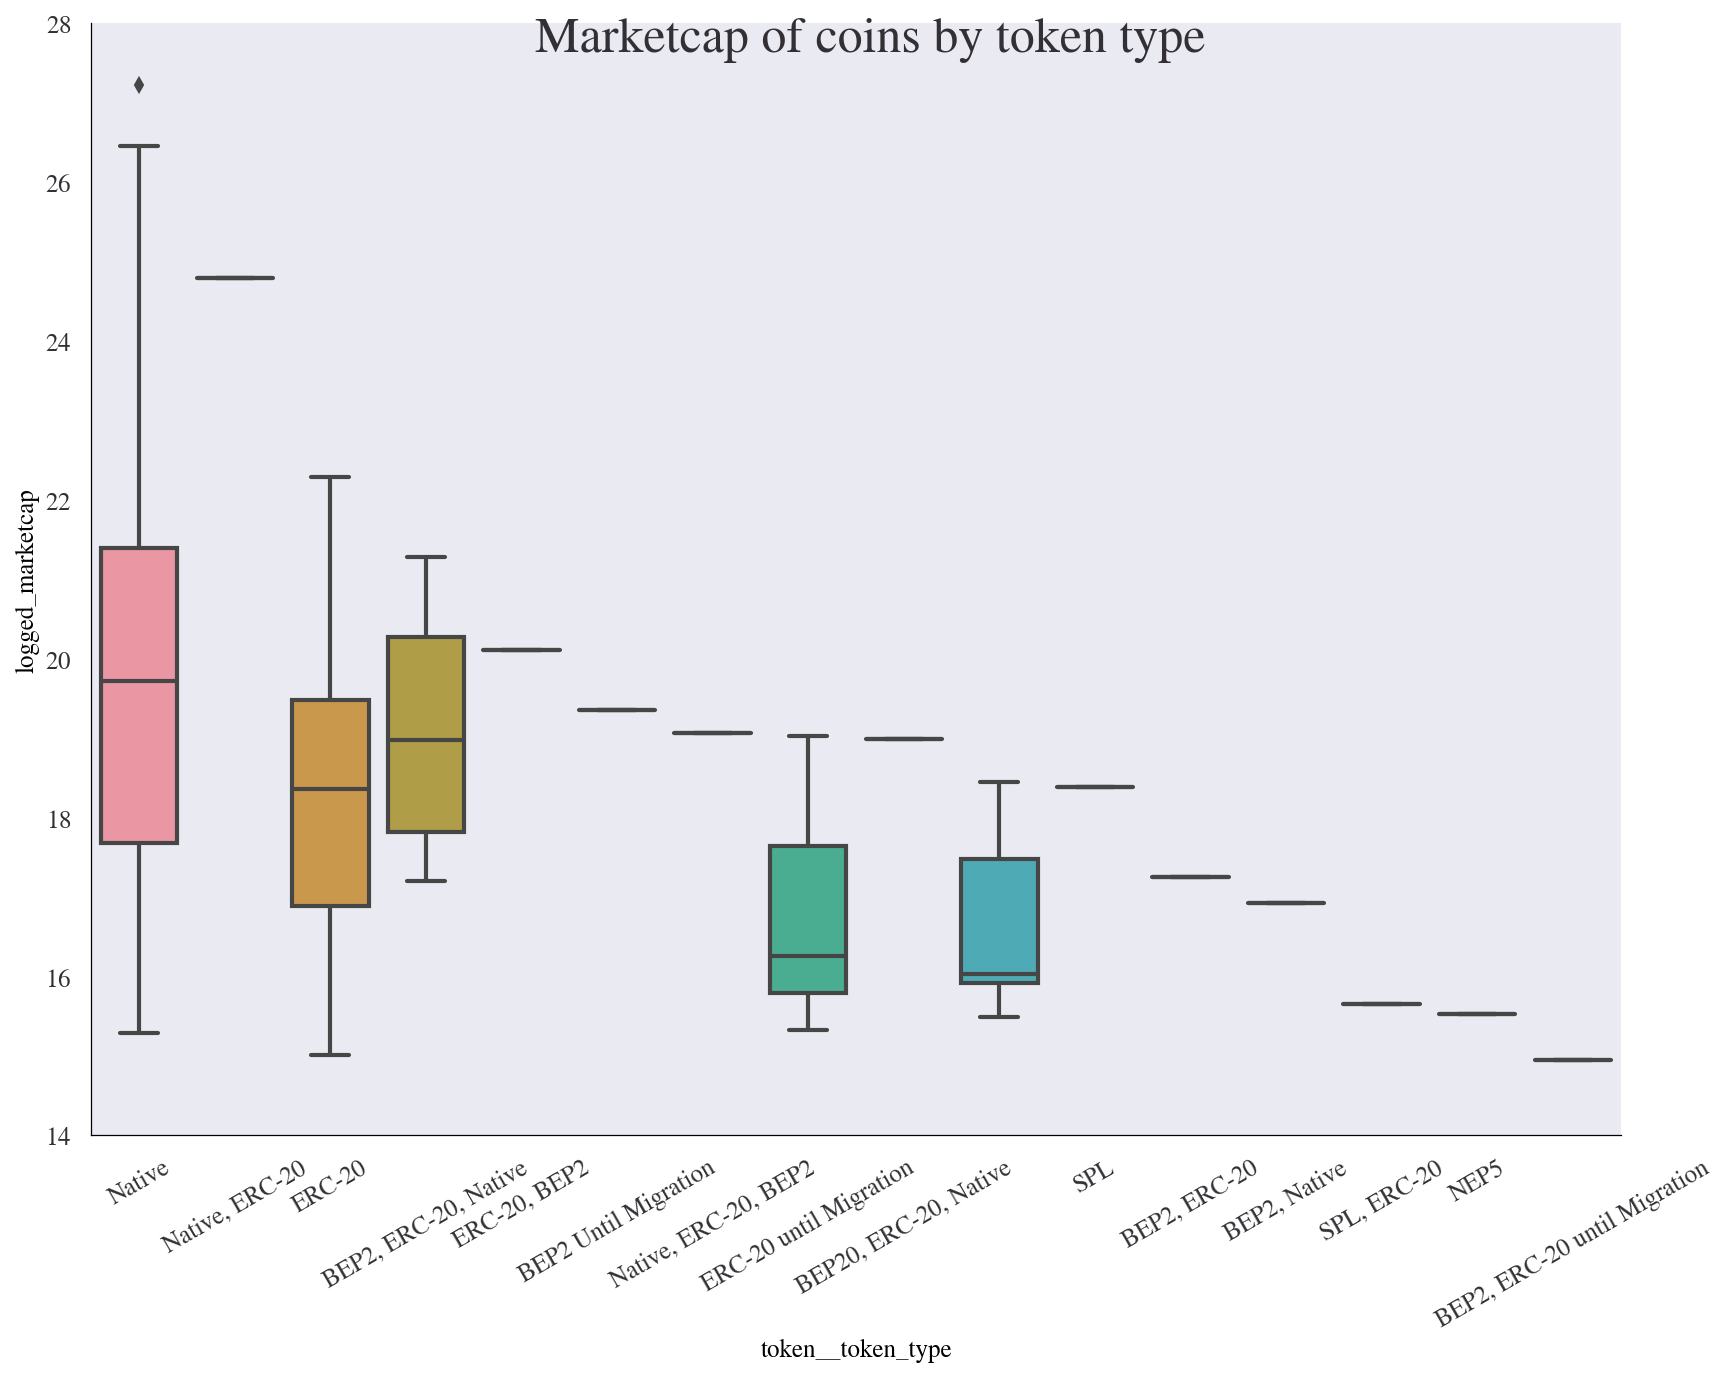

In [ ]:
ax = sns.catplot(x="token__token_type", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=30)
ax.fig.suptitle("Marketcap of coins by token type",
                  fontsize=24, fontdict={"weight": "bold"})

In [ ]:
# median market cap based on launch style
# get average marketcap per year
categorized_df["MedianMarketcap_network"] = (
    combined_df.groupby("token__token_type")
    ["current_marketcap_usd"]
    .transform("median")
) 

#categorized_df[["token__token_type", "MedianMarketcap_network"]]

Text(0, 0.5, 'Market cap')

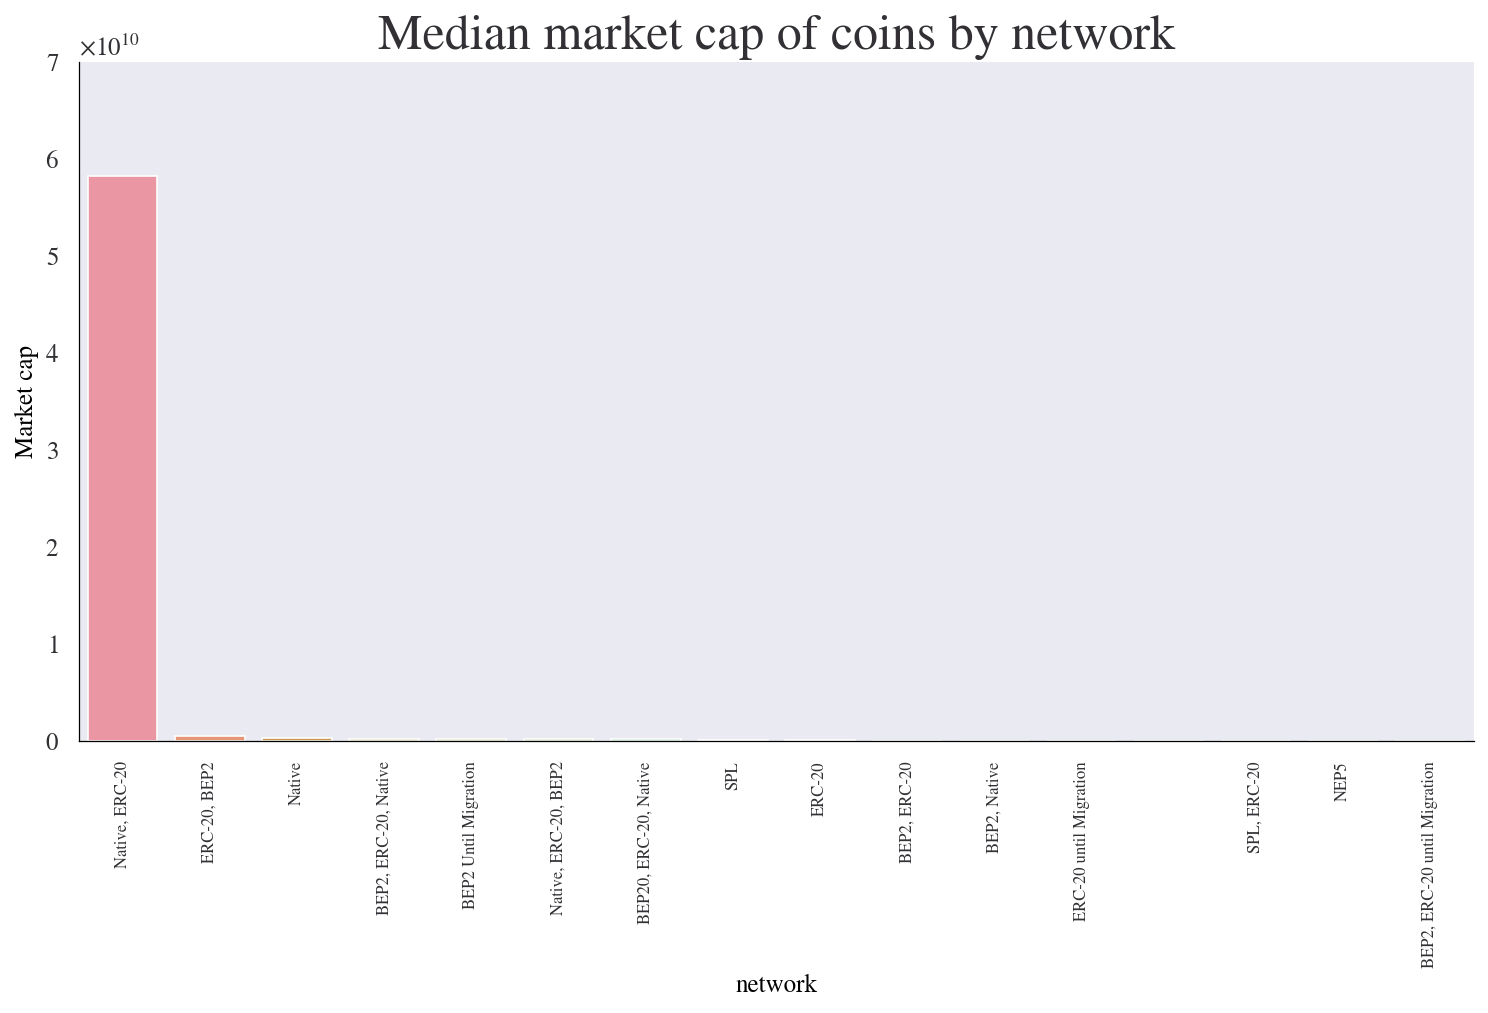

In [ ]:
ax = sns.barplot(x="token__token_type", y="MedianMarketcap_network", data=categorized_df.sort_values(by='MedianMarketcap_network',ascending=False))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by network",fontsize=24,loc='center')
plt.xlabel('network',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

From the data provided, we can see that coins that have both ERC-20 and Native token type have the highest median market cap. There are a few potential reasons for this. THe ERC-20 protocol is a widely used one which makes it easy to exchange between other protocols. It is also can be used by most wallets and DEXes. 
Having its own native protocol could also means that the token potentially offers other potentially useful ..

Text(0.5, 0.98, 'Marketcap of coins by year')

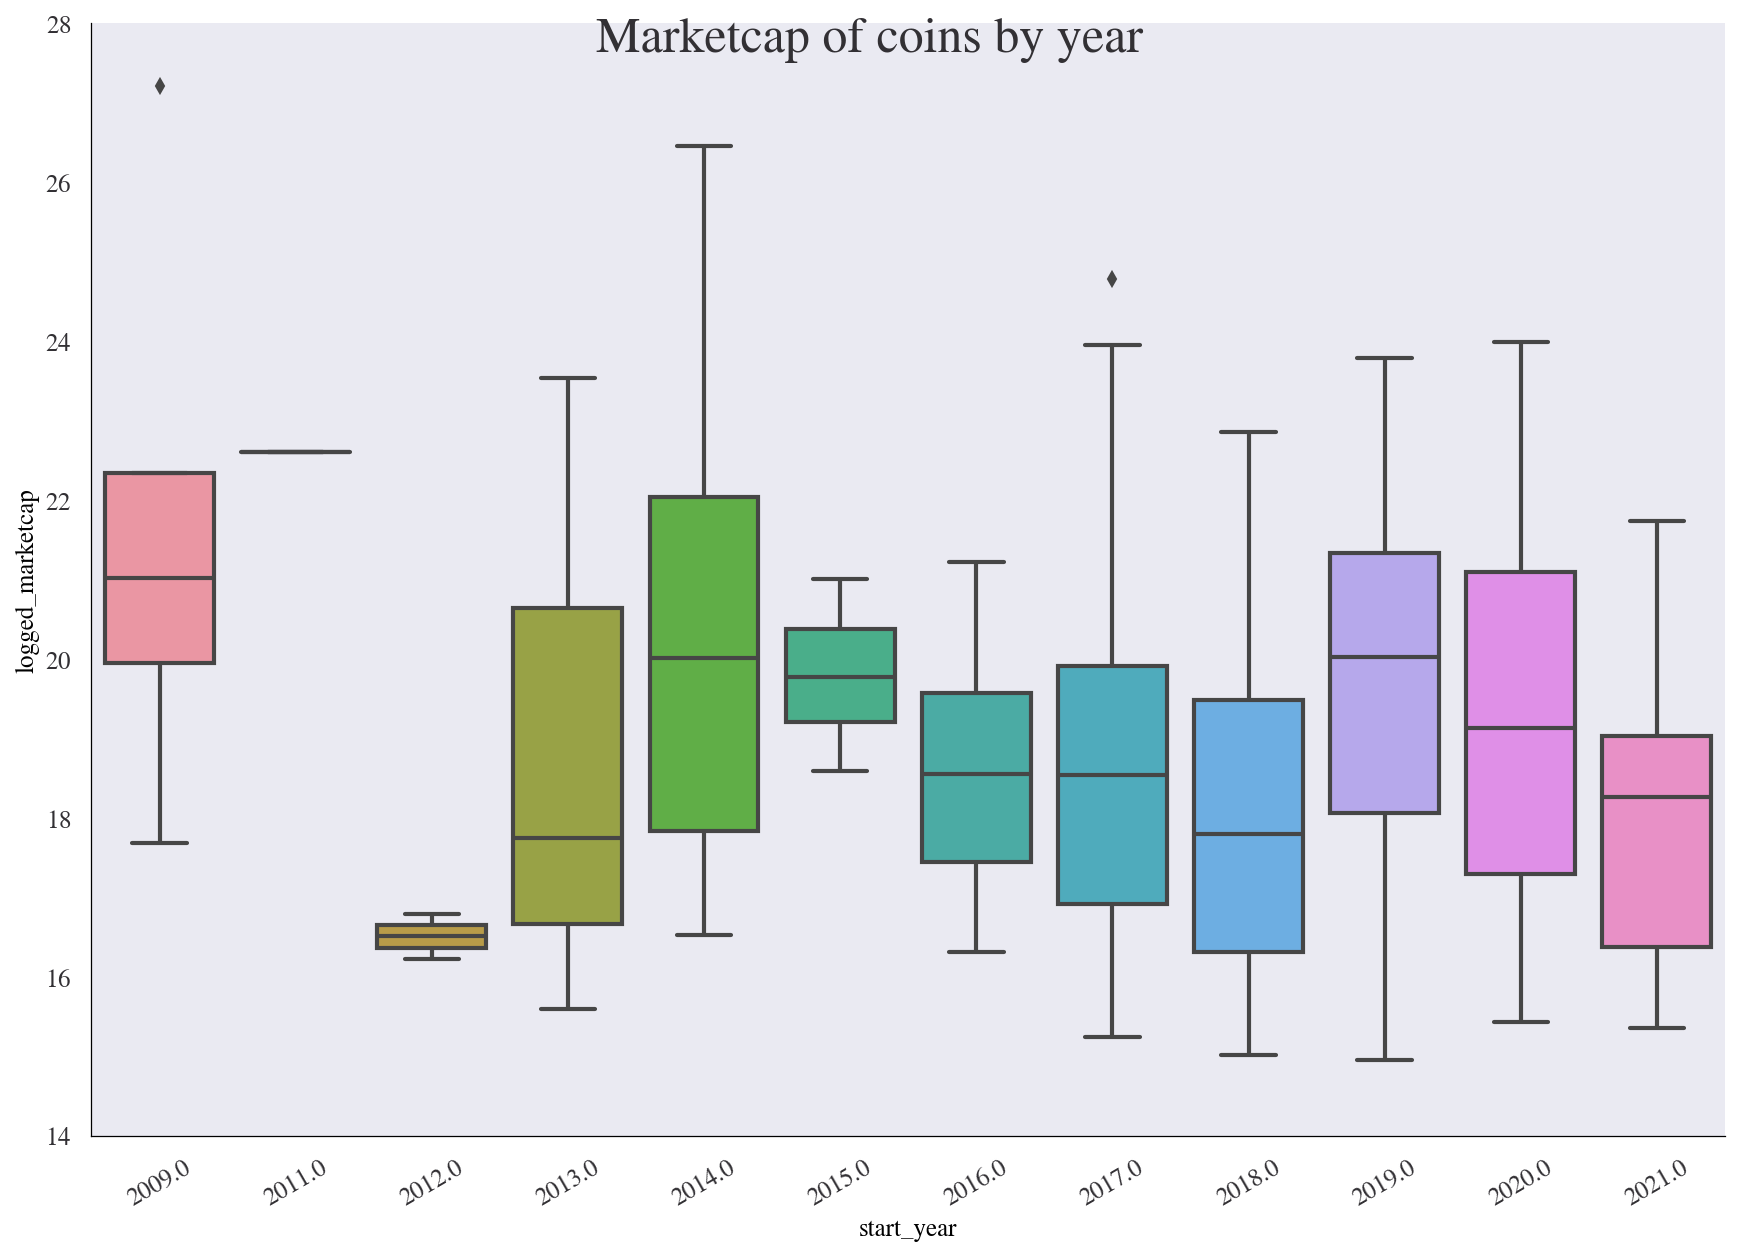

In [ ]:
ax = sns.catplot(x="start_year", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=30)
ax.fig.suptitle("Marketcap of coins by year",
                  fontsize=24, fontdict={"weight": "bold"})

Text(0.5, 1.0, 'Current Median Marketcap of coins by their start year')

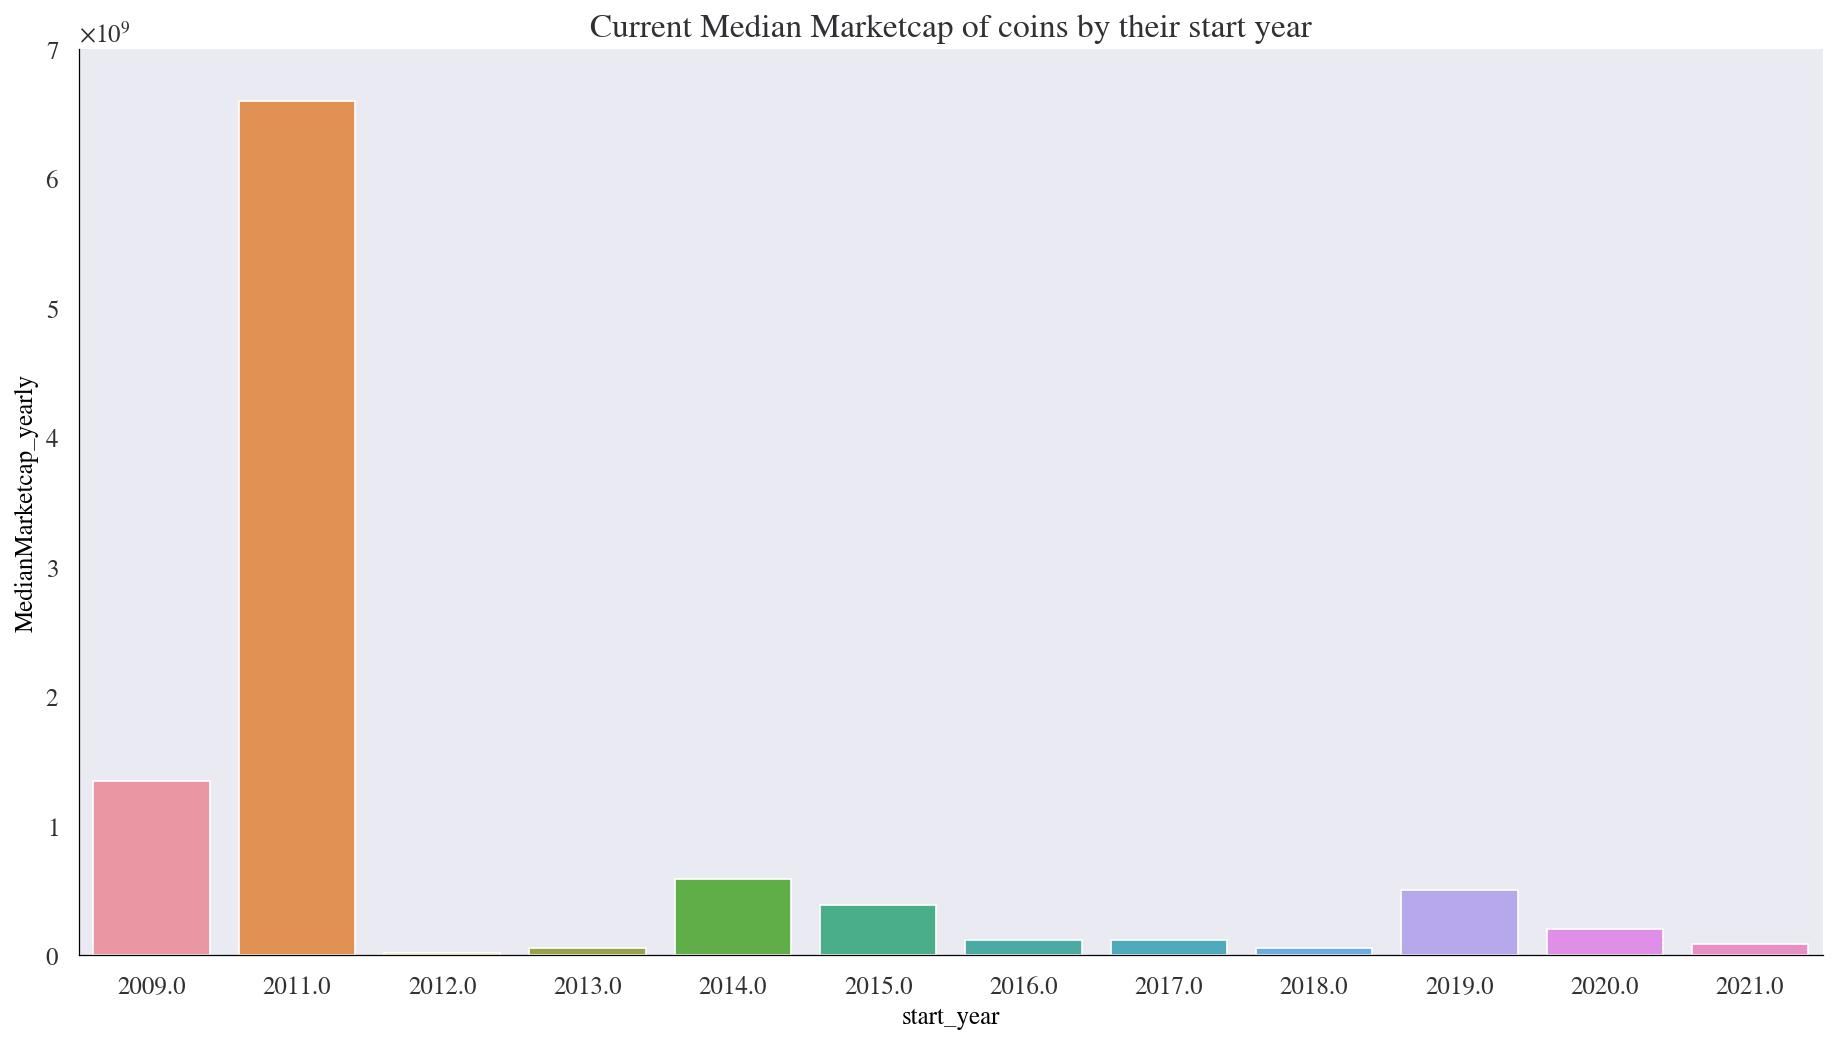

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(data=cleaned_assets, x="start_year", y="MedianMarketcap_yearly")
ax.set_title("Current Median Marketcap of coins by their start year", loc="center",fontsize=16)
# annotate largest coin per year

We also want to see whether start year is correlated to a coins market cap. We might hypothesize that older coins tend to have a higher median market cap for (2009 and 2011) but this trend is not consistent. Coins started in 2014 was higher than those started in 2013 and ones started in 2019 was higher than the those started in last 4 years

Text(0.5, 0.98, 'Marketcap of coins by general launch style')

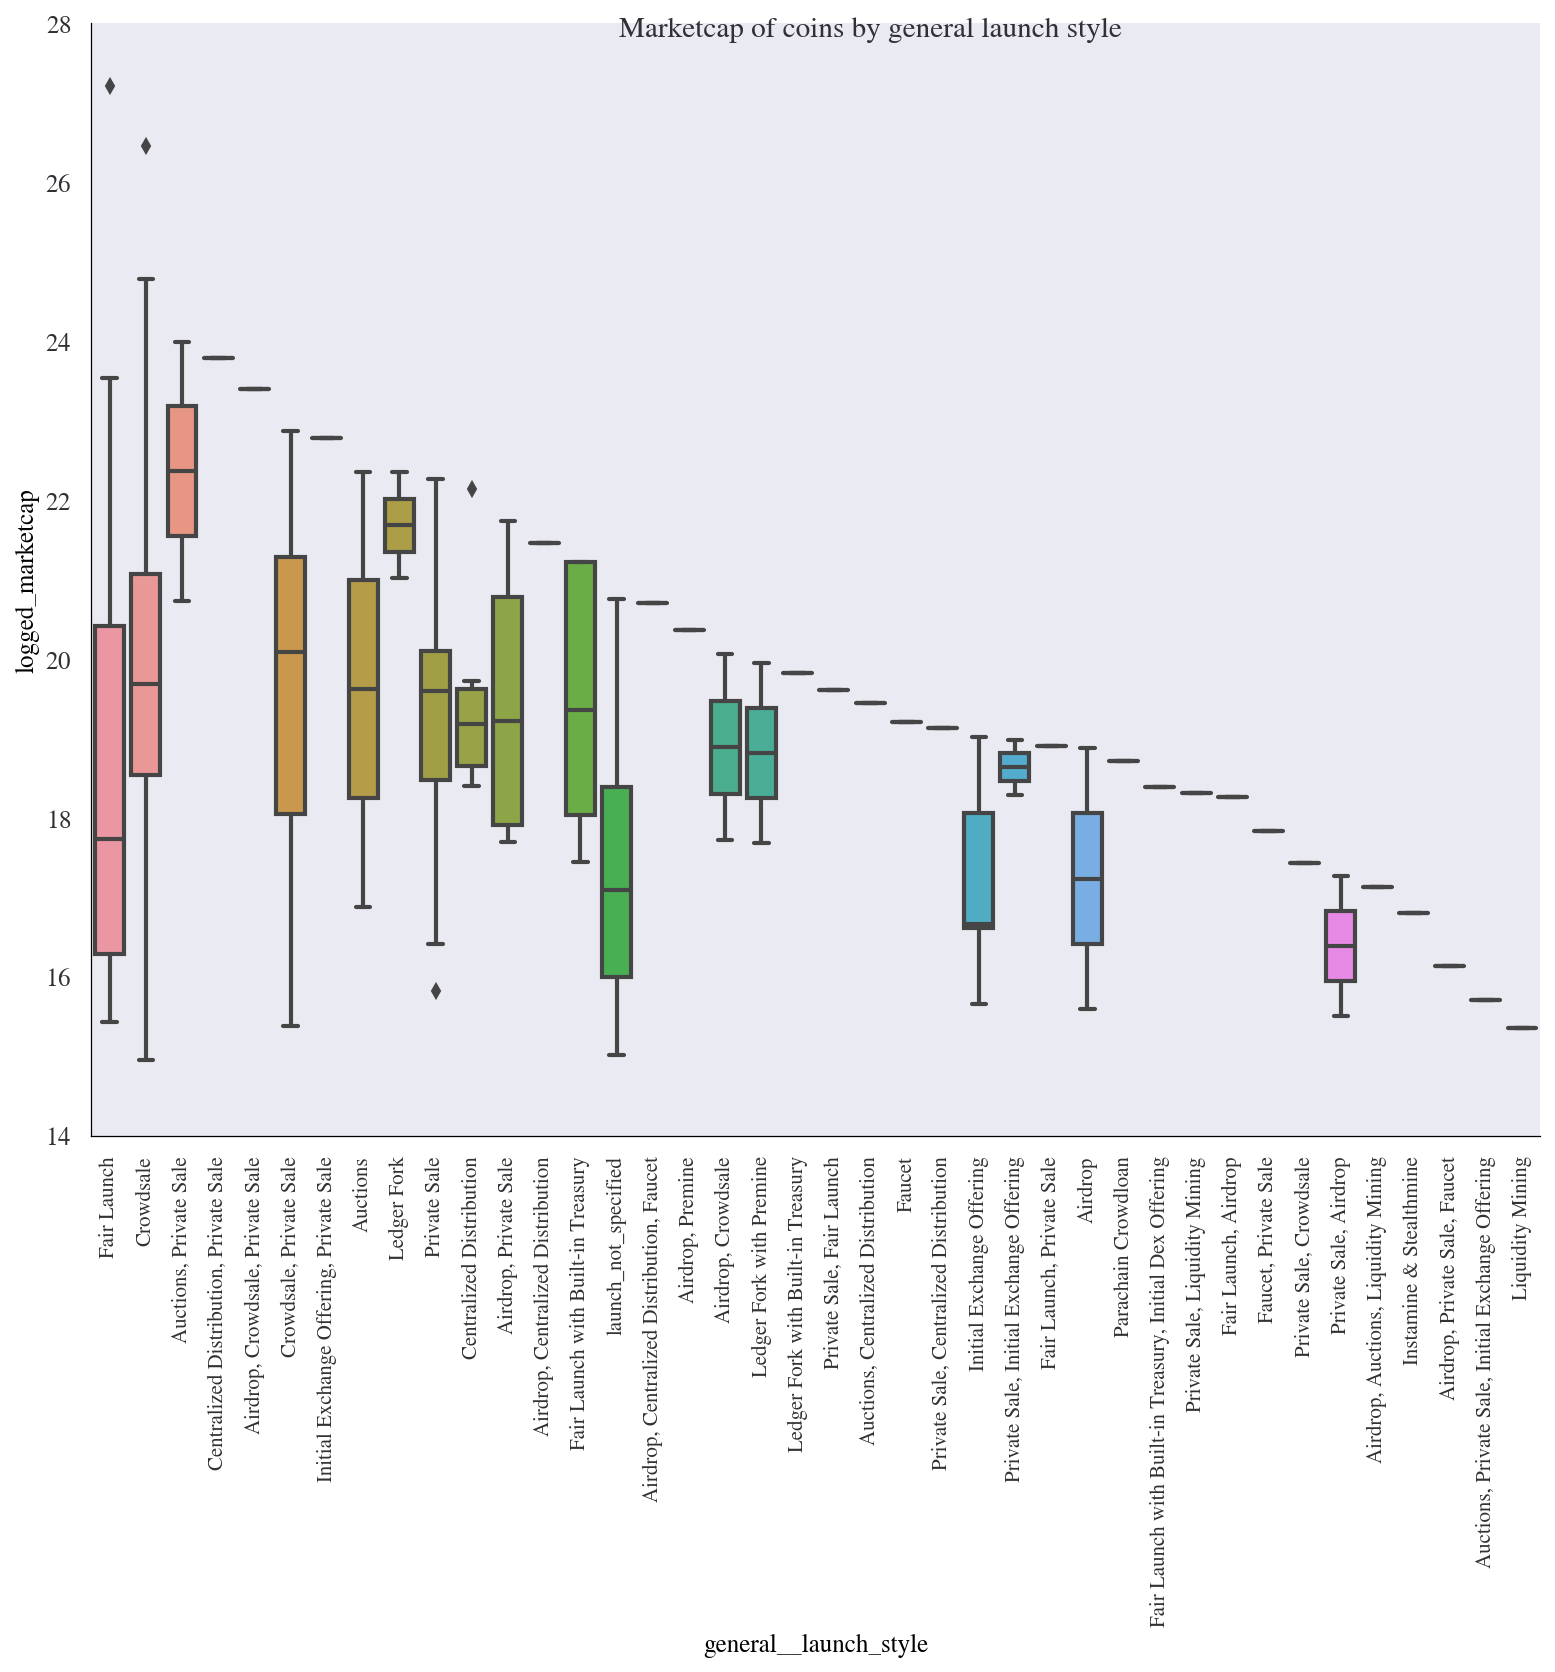

In [ ]:
ax = sns.catplot(x="general__launch_style", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=90,fontsize=10)
ax.fig.suptitle("Marketcap of coins by general launch style",
                  fontsize=14, fontdict={"weight": "bold"})

In [ ]:
# median market cap based on launch style
categorized_df["MedianMarketcap_launchstyle"] = (
    combined_df.groupby("general__launch_style")
    ["current_marketcap_usd"]
    .transform("median")
) 

categorized_df[["general__launch_style", "MedianMarketcap_launchstyle"]].head(10)

general__launch_style  MedianMarketcap_launchstyle
0                              Fair Launch                 5.050224e+07
1                                Crowdsale                 3.532605e+08
3                                Crowdsale                 3.532605e+08
6                   Auctions, Private Sale                 1.366692e+10
7                                Crowdsale                 3.532605e+08
8   Centralized Distribution, Private Sale                 2.133582e+10
11                             Fair Launch                 5.050224e+07
12        Airdrop, Crowdsale, Private Sale                 1.444531e+10
13                               Crowdsale                 3.532605e+08
16                 Crowdsale, Private Sale                 5.316205e+08

Text(0, 0.5, 'Market cap')

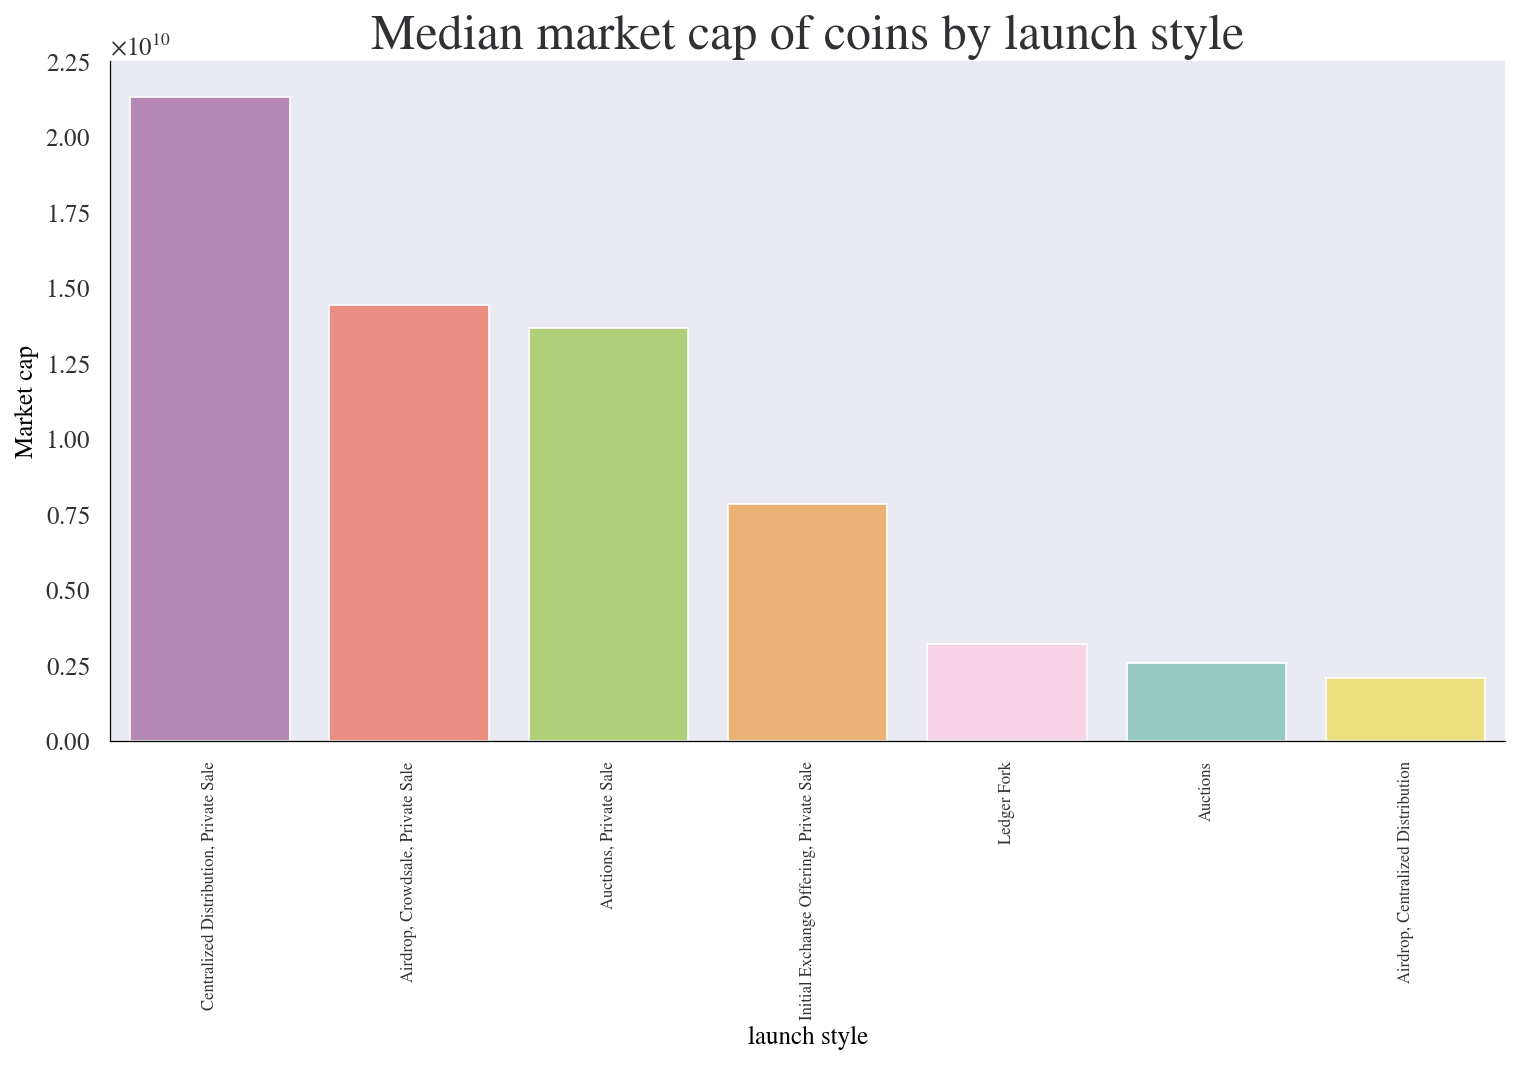

In [ ]:
ax = sns.barplot(x="general__launch_style", y="MedianMarketcap_launchstyle", data=categorized_df.sort_values(by='MedianMarketcap_launchstyle',ascending=False).head(10))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by launch style",fontsize=24,loc="center")
plt.xlabel('launch style',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

A coin's launch style also seems to be correlated to its future market cap. Those that have a Centralized distribution and Private sale launch style tend to be worth more as oppossed to other launch styles. This could be that coins that were most centralized (initially) were easier to patch and update compared to those that were already decentralized from the beginning. 

Text(0.5, 0.98, 'Marketcap of coins by general emission type')

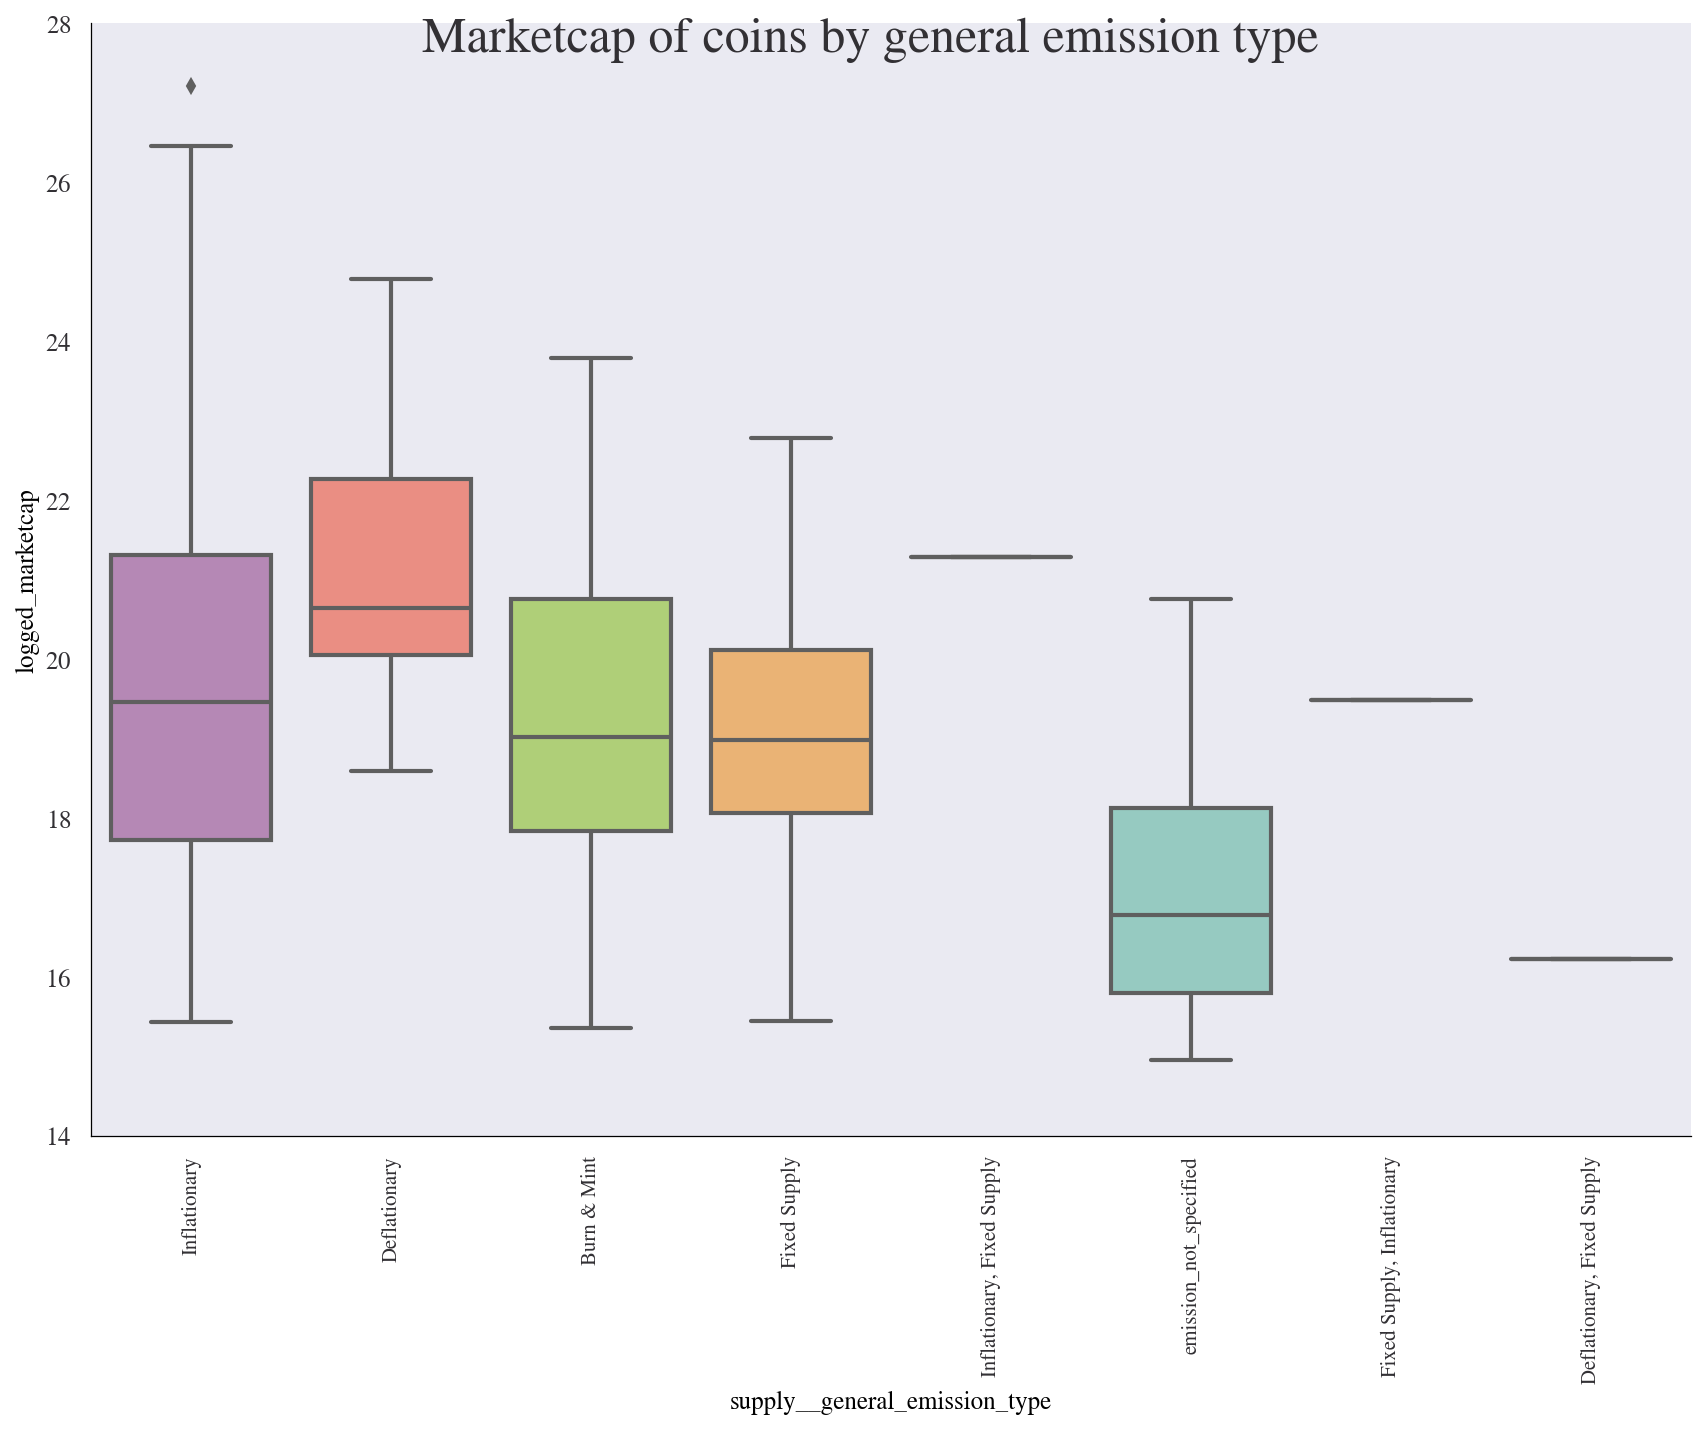

In [ ]:
#categorized_df['supply__general_emission_type'].value_counts()
ax = sns.catplot(x="supply__general_emission_type", y="logged_marketcap", kind="box",data=cleaned_assets, height=8.27, aspect=11.7/8.27)
ax.set_xticklabels(rotation=90,fontsize=10)
ax.fig.suptitle("Marketcap of coins by general emission type",
                  fontsize=24, fontdict={"weight": "bold"})

In [ ]:
# median market cap based on emission type 
# get average marketcap per year
categorized_df["MedianMarketcap_emissiontype"] = (
    combined_df.groupby("supply__general_emission_type")
    ["current_marketcap_usd"]
    .transform("median")
) 

#categorized_df[["general__launch_style", "MedianMarketcap_emissiontype"]].head(10)

Text(0, 0.5, 'Market cap')

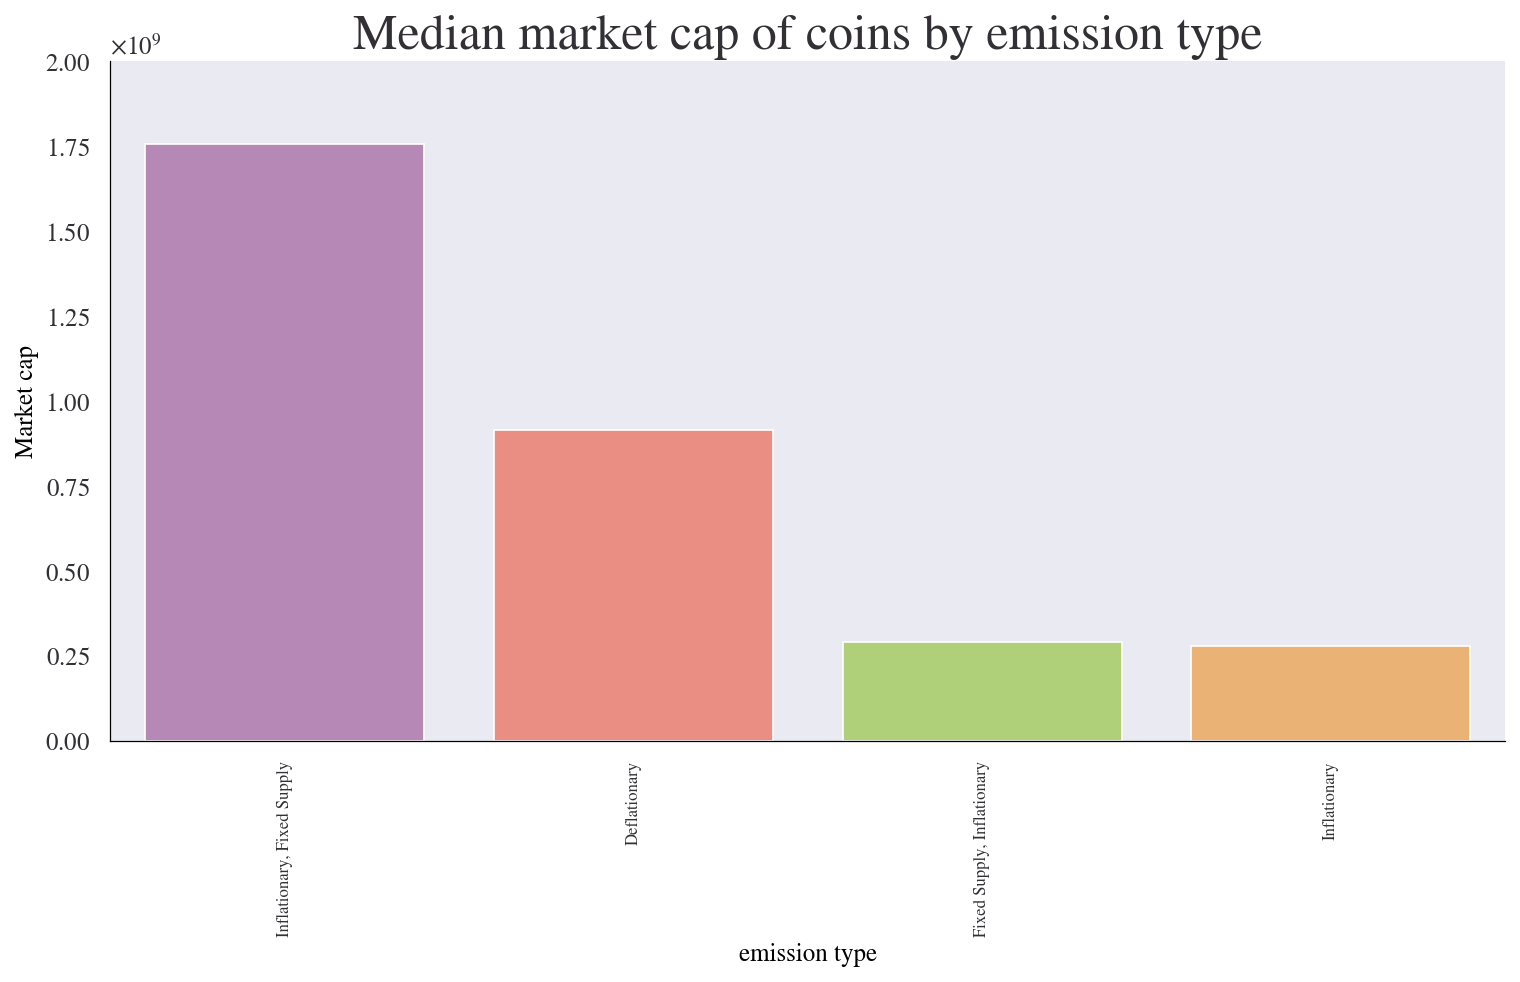

In [ ]:
ax = sns.barplot(x="supply__general_emission_type", y="MedianMarketcap_emissiontype", data=categorized_df.sort_values(by='MedianMarketcap_emissiontype',ascending=False).head(10))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by emission type",fontsize=24,loc="center")
plt.xlabel('emission type',fontsize=12)
plt.ylabel('Market cap',fontsize=12)

In [ ]:
categorized_df["MedianMarketcap_precise_emissiontype"] = (
    combined_df.groupby("supply__precise_emission_type")
    ["current_marketcap_usd"]
    .transform("median")
) 

Text(0, 0.5, 'Median Market cap')

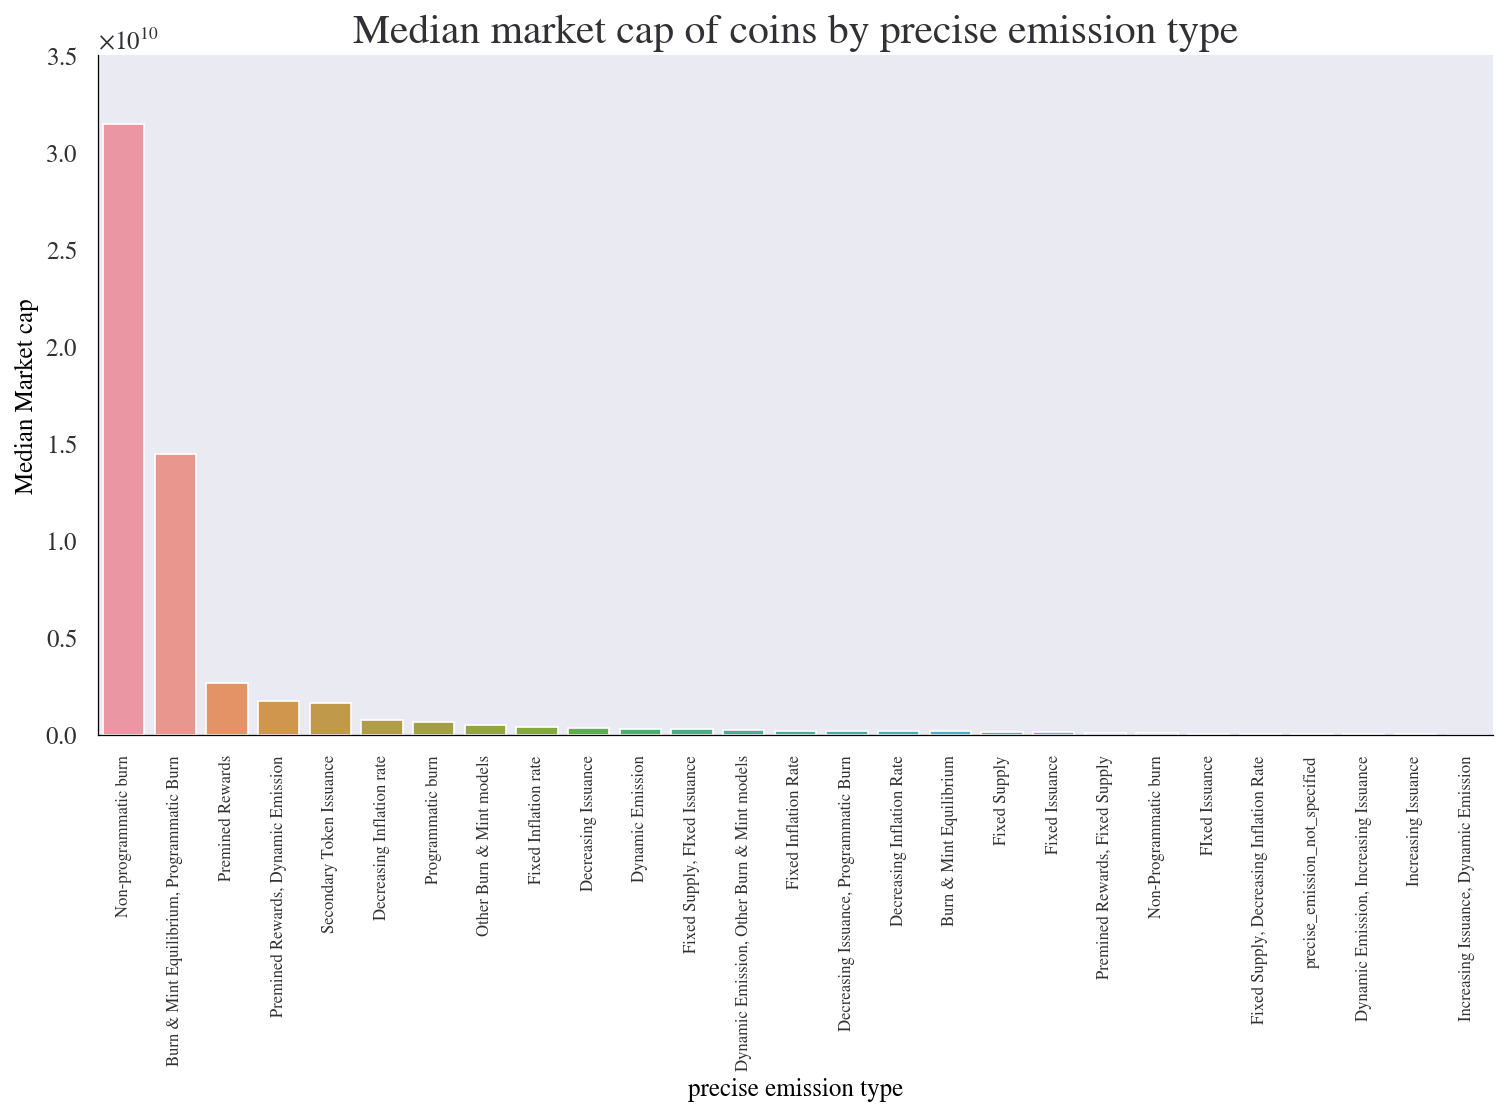

In [ ]:
ax = sns.barplot(x="supply__precise_emission_type", y="MedianMarketcap_precise_emissiontype", data=categorized_df.sort_values(by='MedianMarketcap_precise_emissiontype',ascending=False))
plt.xticks(rotation=90,fontsize=8)
plt.gcf().set_size_inches(12,6)
plt.title("Median market cap of coins by precise emission type",fontsize=20, loc="center")
plt.xlabel('precise emission type',fontsize=12)
plt.ylabel('Median Market cap',fontsize=12)

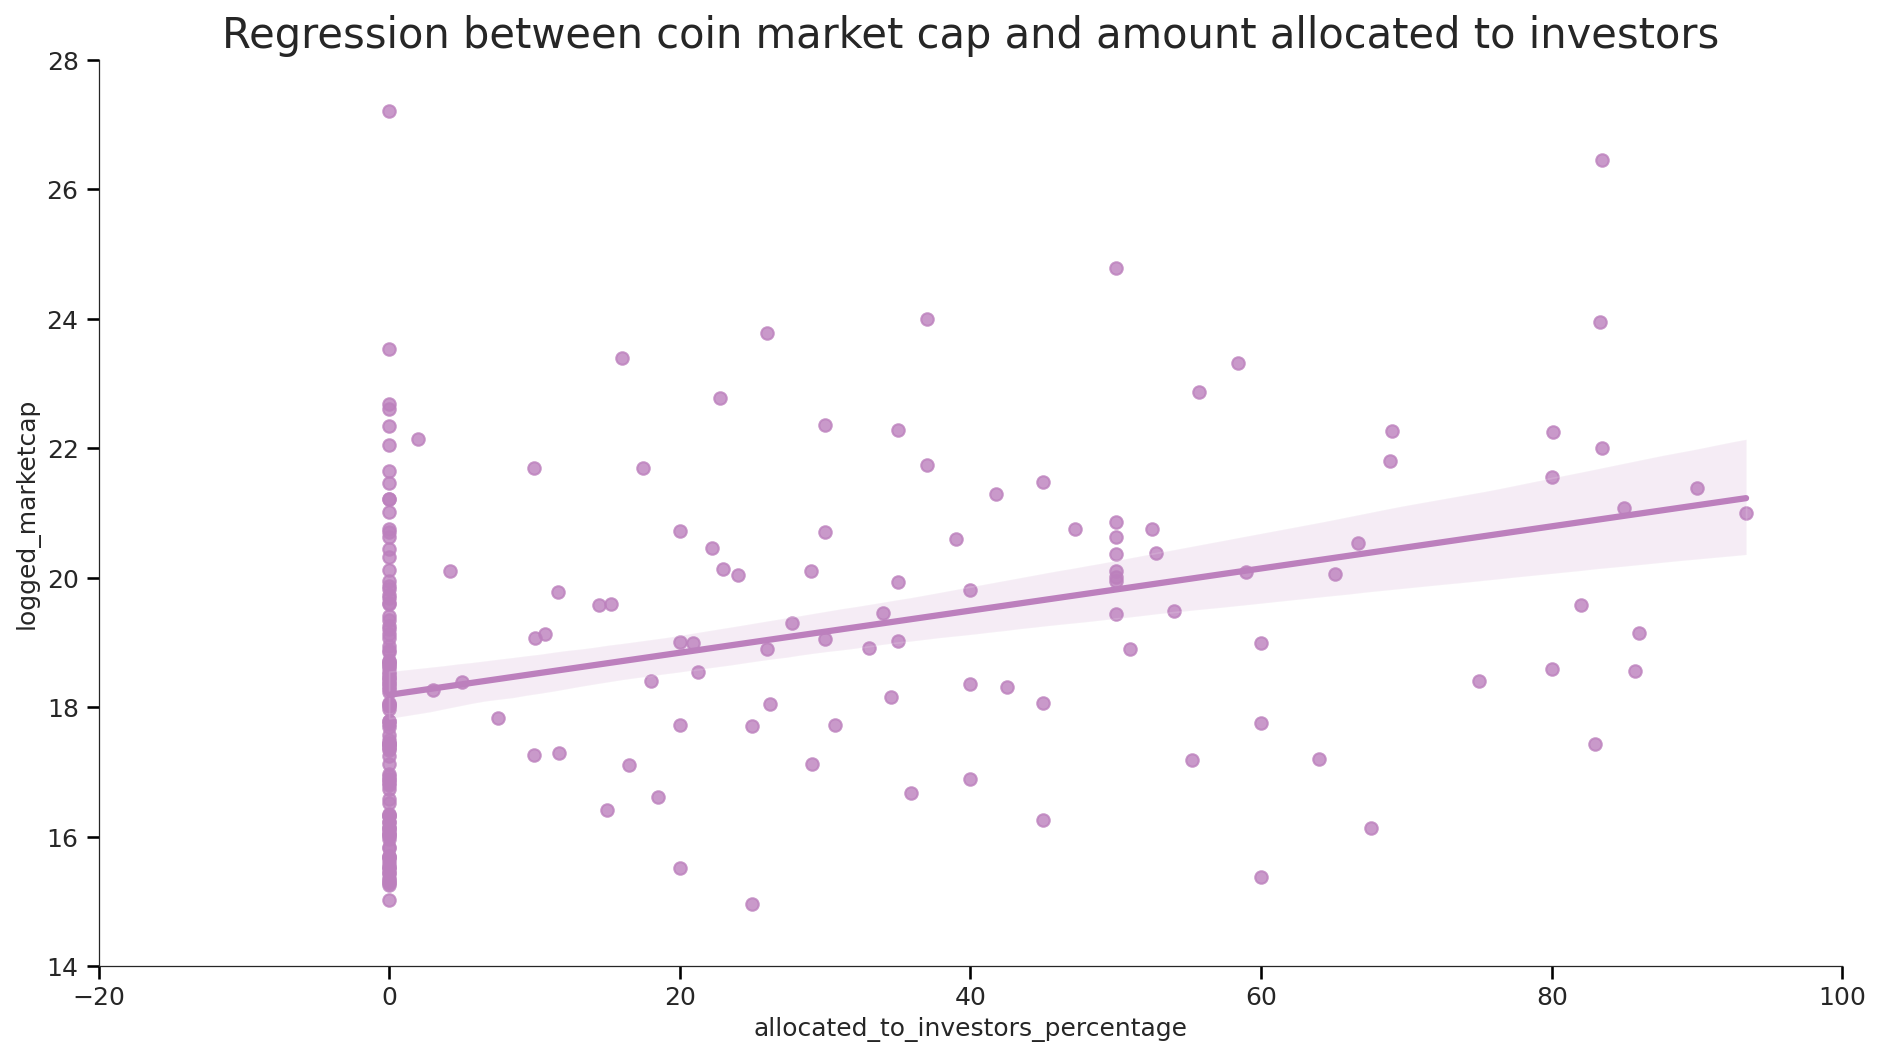

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_investors_percentage", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and amount allocated to investors", loc="center",fontsize=20)
sns.despine()

#ax = sns.regplot(x="allocated_to_investors_percentage", x="allocated_to_investors_percentage", data=cleaned_assets)

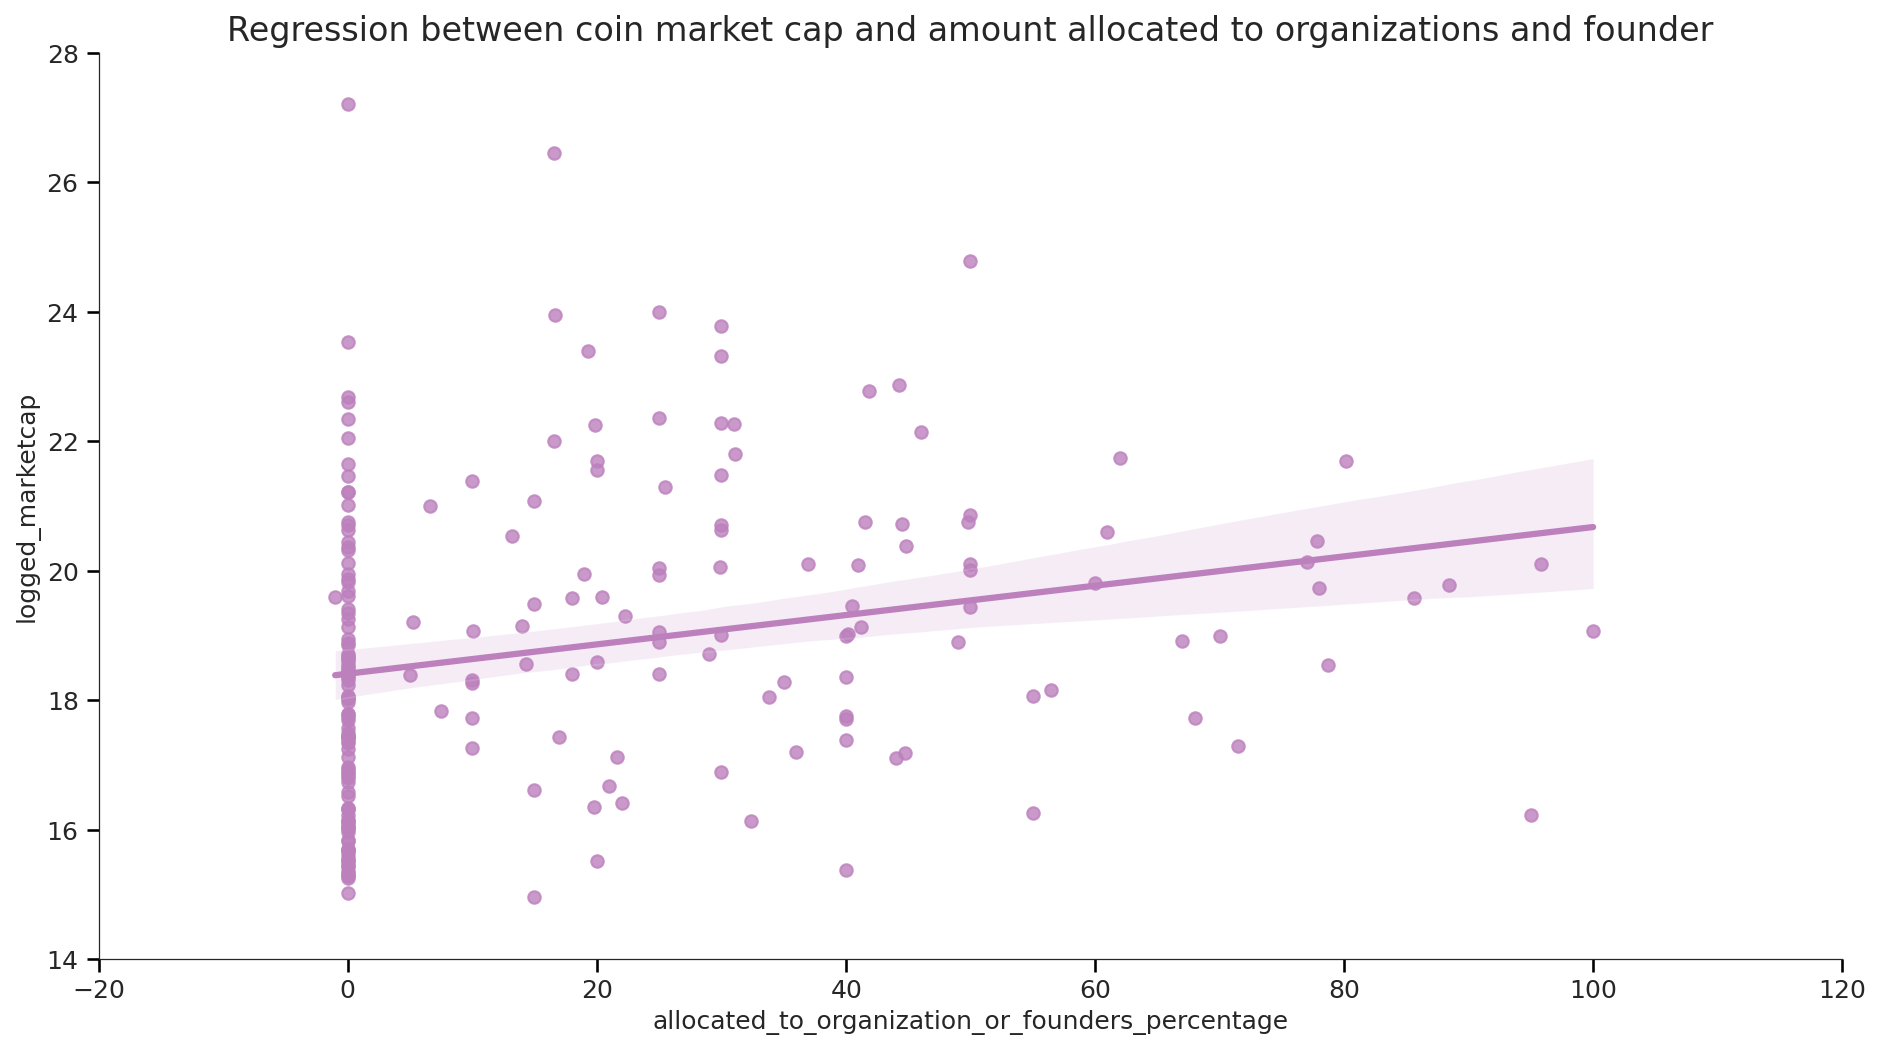

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_organization_or_founders_percentage", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and amount allocated to organizations and founder", loc="center")
sns.despine()


## Removing 0s from founder

In [ ]:
alloc_founders = cleaned_assets[['asset','allocated_to_organization_or_founders_percentage','current_marketcap_usd','logged_marketcap']]

alloc_founders  = alloc_founders[alloc_founders['allocated_to_organization_or_founders_percentage'] != 0]
alloc_founders.shape

(107, 4)

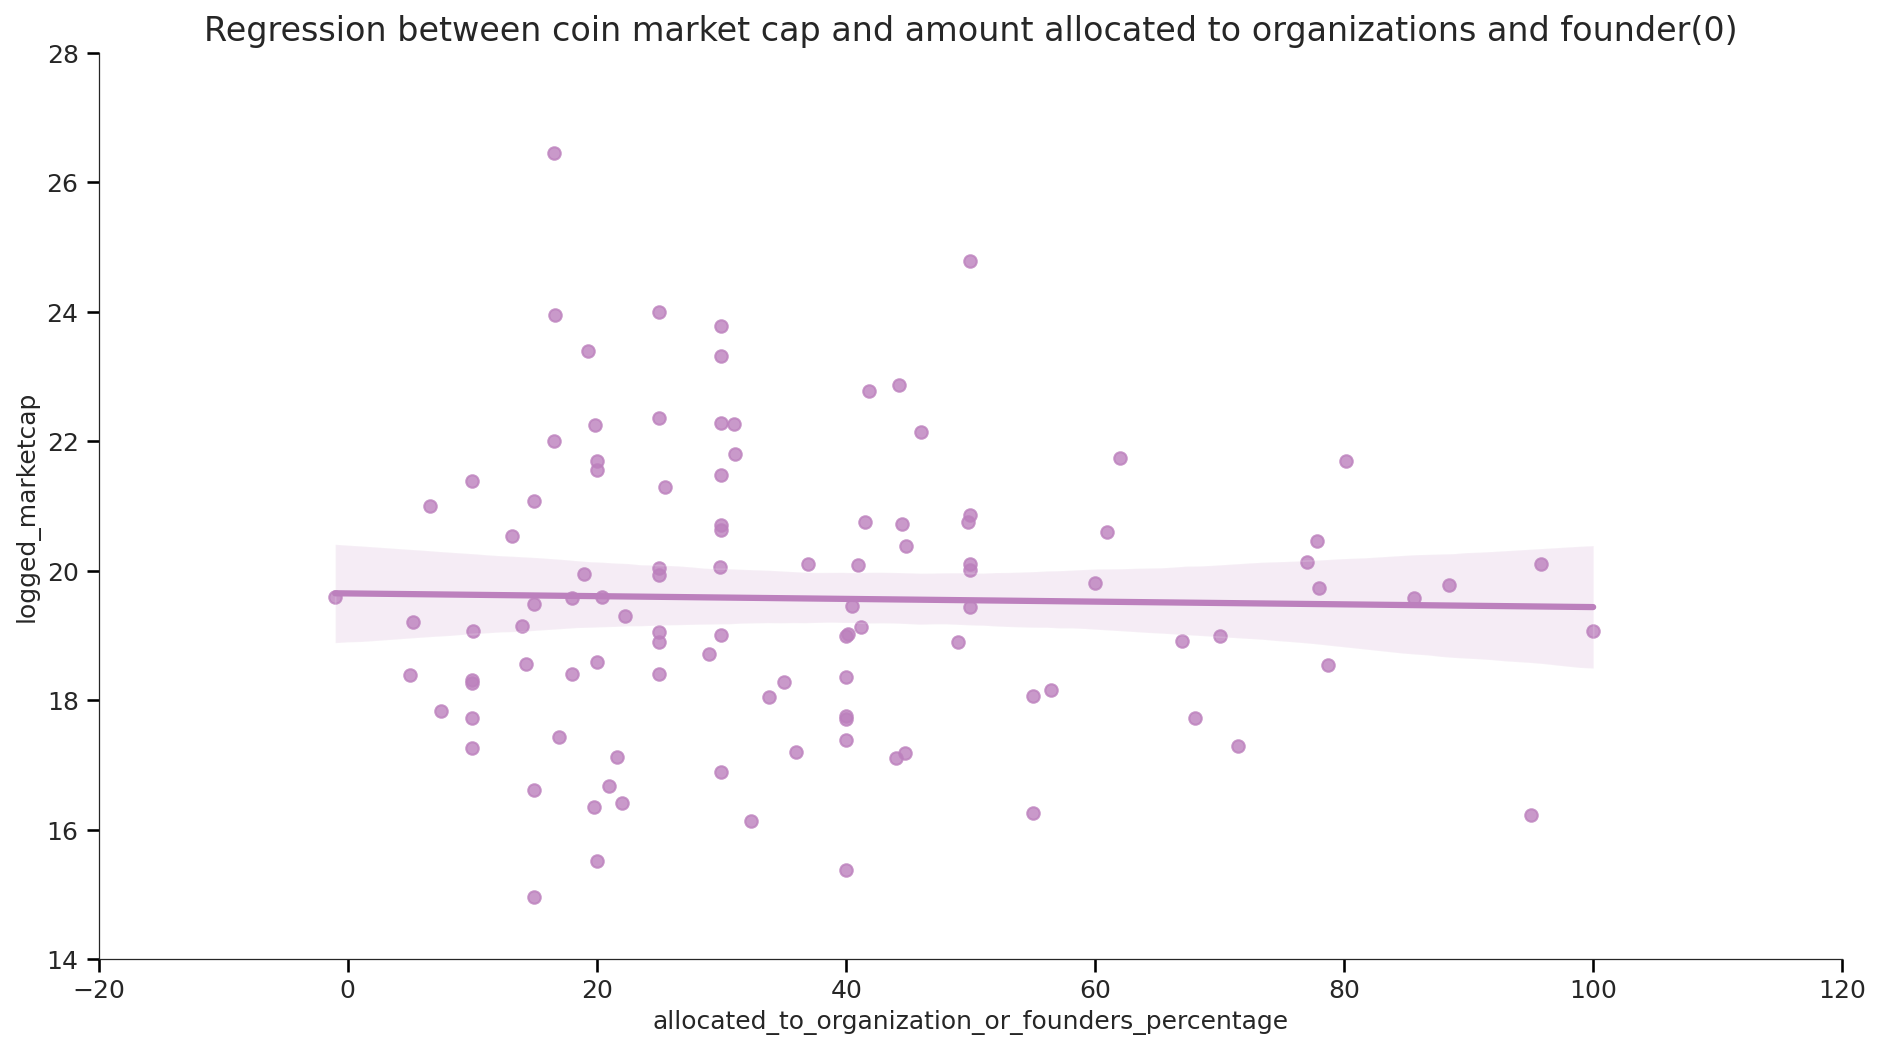

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_organization_or_founders_percentage", y="logged_marketcap", ax=ax,data=alloc_founders)
ax.set_title("Regression between coin market cap and amount allocated to organizations and founder(0)", loc="center")
sns.despine()

## removing 0s from investors

In [ ]:
alloc_invest = cleaned_assets[['asset','allocated_to_investors_percentage','current_marketcap_usd','logged_marketcap']]
alloc_invest  = alloc_invest[alloc_invest['allocated_to_investors_percentage'] != 0]
alloc_invest.shape

(99, 4)

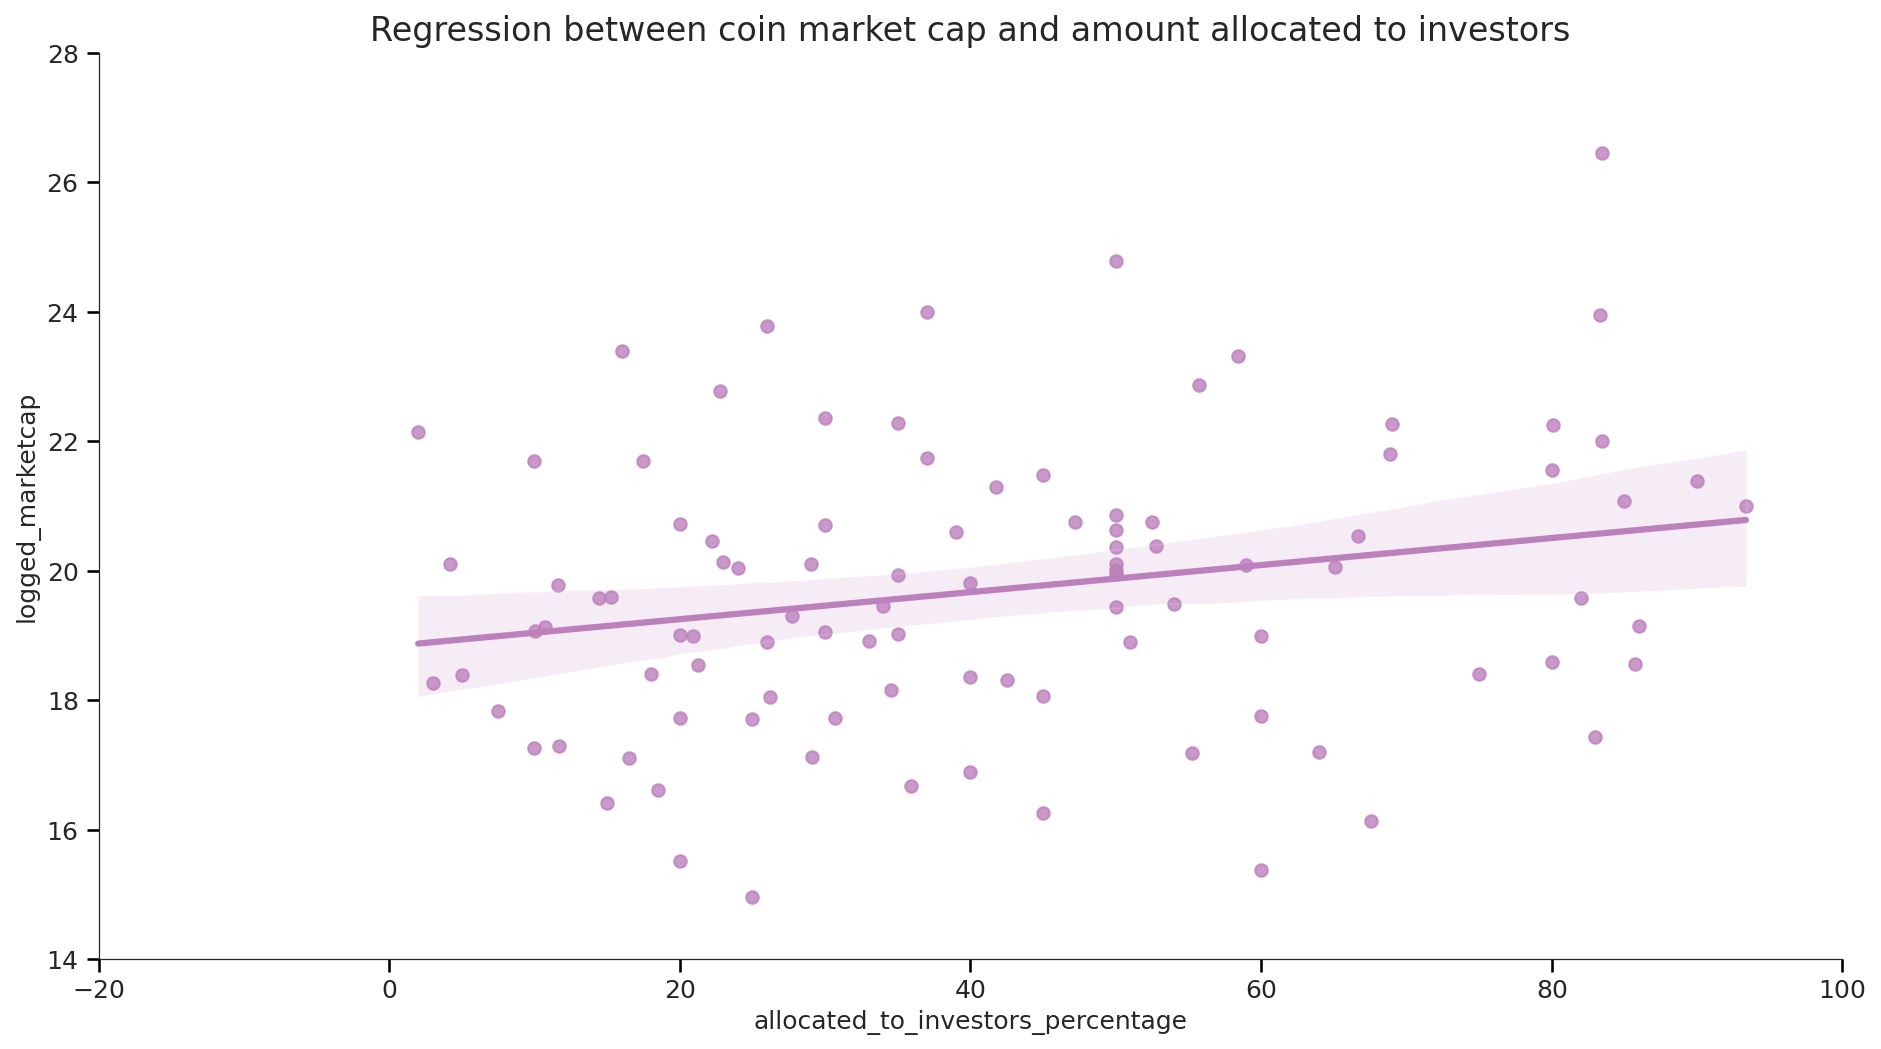

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="allocated_to_investors_percentage", y="logged_marketcap", ax=ax,data=alloc_invest)
ax.set_title("Regression between coin market cap and amount allocated to investors", loc="center")
sns.despine()


In [ ]:
cleaned_assets.head(2)

asset  current_marketcap_usd   circulating  percent_change_last_1_week  \
0   bitcoin           6.596436e+11  1.903264e+07                   -9.569280   
1  ethereum           3.091416e+11  1.206741e+08                   -8.935813   

   percent_change_btc_last_1_week  percent_change_eth_last_1_week  \
0                        0.000000                       -0.700324   
1                        0.704918                        0.000000   

   percent_change_month_to_date  percent_change_quarter_to_date  \
0                     -9.569280                      -24.850741   
1                     -8.935813                      -25.565467   

   percent_change_year_to_date  sharpe_ratios__last_30_days  \
0                   -27.116804                    -3.751188   
1                   -31.695333                    -3.073505   

   volatility_stats__volatility_last_30_days token__token_type  \
0                                   0.543354            Native   
1                                   0.584664            Native   

  general__launch_style supply__general_emission_type  \
0           Fair Launch                  Inflationary   
1             Crowdsale                  Inflationary   

  supply__precise_emission_type supply__is_capped_supply  \
0           Decreasing Issuance                     True   
1                Fixed Issuance                    False   

  consensus__general_consensus_mechanism  PROOF-OF-WORK  \
0                          PROOF-OF-WORK            1.0   
1                          PROOF-OF-WORK            1.0   

   DELEGATED PROOF-OF-STAKE  HYBRID POW & POS  PROOF-OF-STAKE, DAG  DAG  \
0                       0.0               0.0                  0.0  0.0   
1                       0.0               0.0                  0.0  0.0   

   PROOF-OF-WORK, OTHER  PROOF-OF-STAKE, OTHER  HYBRID POW & DPOS  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   

   allocated_to_investors_percentage  \
0                               0.00   
1                              83.47   

   allocated_to_organization_or_founders_percentage  erc20  native  omni  \
0                                              0.00    0.0     1.0   0.0   
1                                             16.53    0.0     1.0   0.0   

   trc20  trc10  bep2  bep20  erc777  ardor  spl  eosio  usage__payments  \
0    0.0    0.0   0.0    0.0     0.0    0.0  0.0    0.0              1.0   
1    0.0    0.0   0.0    0.0     0.0    0.0  0.0    0.0              1.0   

   usage__work  usage__access  usage__discount  usage__vote  usage__dividends  \
0          0.0            0.0              0.0          0.0               0.0   
1          1.0            0.0              0.0          0.0               0.0   

   start_year              R1 type marketcap_categories  \
0      2009.0  R1_type_not_specied            very high   
1      2014.0  R1_type_not_specied            very high   

   MedianMarketcap_yearly  logged_marketcap  
0            1.342765e+09         27.214965  
1            5.861808e+08         26.457065

In [ ]:
cleaned_assets['logged_medianmarketcap'] = np.log(cleaned_assets["MedianMarketcap_yearly"]) # scales better

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


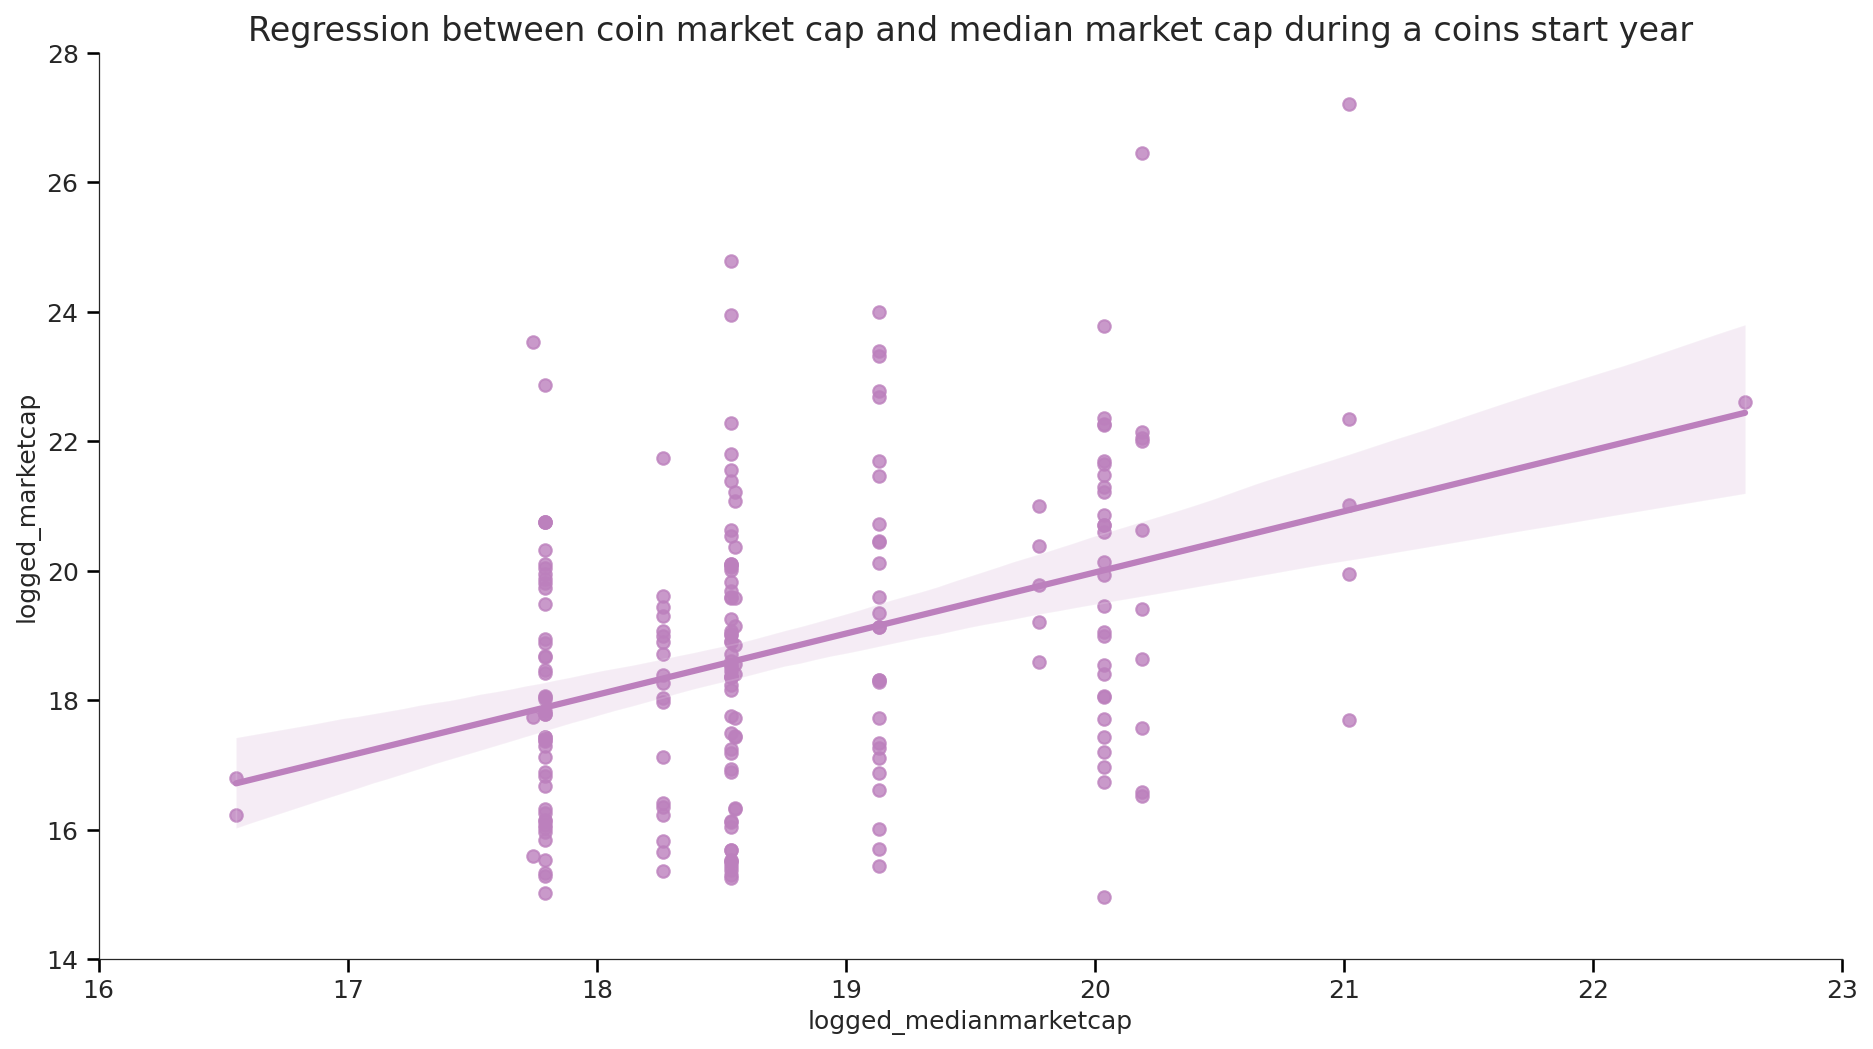

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.regplot(x="logged_medianmarketcap", y="logged_marketcap", ax=ax,data=cleaned_assets)
ax.set_title("Regression between coin market cap and median market cap during a coins start year", loc="center")
sns.despine()


# Build  1st model

In [ ]:
X = cleaned_assets.copy()
X = X.drop(drop_more_cols,axis=1) # data leak cols
X = X.drop(columns=['logged_marketcap','current_marketcap_usd','asset','circulating','token__token_type','marketcap_categories']) # target

# Flagging different vars

As these variables were deemed important by our MI scores and are categorical, we create dummy variables for each category within the feature.

In [ ]:
X = pd.concat([X, X['general__launch_style'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['supply__general_emission_type'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['supply__precise_emission_type'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['supply__is_capped_supply'].str.get_dummies(sep=',')], axis=1)
X = pd.concat([X, X['R1 type'].str.get_dummies(sep=',')], axis=1)

# Drop flagged categories

In [ ]:
X = X.drop(columns=['general__launch_style','supply__general_emission_type',
                    'supply__precise_emission_type','supply__is_capped_supply',
                    'R1 type','consensus__general_consensus_mechanism'])

# Label encode target variable

In [ ]:
#label_encoder = LabelEncoder()
#cleaned_assets['marketcap_categories'] = label_encoder.fit_transform(cleaned_assets['marketcap_categories'])

#split our dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = cleaned_assets[['marketcap_categories']]
X = X.loc[:,~X.columns.duplicated()] # certain cols were duplicates
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,shuffle=True)

# scale our variables

In [ ]:
# scaler = StandardScaler()
# scaler.fit(train_X)  # No cheating, never scale on the training+test!
# train_X = scaler.transform(train_X)
# val_X = scaler.transform(val_X)

# Random Forest

In [ ]:
my_model = RandomForestClassifier(n_estimators=8000,
                                 random_state=23).fit(train_X, train_y.values.ravel())
y_pred = my_model.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.33962264150943394


# Xgboost

We use both Random Forest and XGBoost to predict a coin's future market cap. We utilized grid search to find the optimal hyperparameters for our XGBoost model.

In [ ]:
#  grid search to find optimal hyper parameters
# gbm_param_grid = {
#     'learning_rate' : [0.07,0.06],
#     'colsample_bytree': [0.8,0.7],
#     'n_estimators': [50,100.75],
#     'max_depth': [10,15],
#     'gamma' : [0.1,1,5],
#     'objective': ['multi:softmax']
# } 

# xgb_model = xgb.XGBClassifier()
# grid_acc = GridSearchCV(estimator=xgb_model,param_grid=gbm_param_grid, cv=4, verbose=1)
# grid_acc.fit(X,y.values.ravel())

# print("Best parameters found: ", grid_acc.best_params_)
# print( "best score : ",grid_acc.best_score_)

In [ ]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', n_estimators=50,
                              learning_rate=0.07,max_depth=5,gamma=5,colsample_bytree=0.7)

xgb_model.fit(train_X, train_y.values.ravel())
y_pred = xgb_model.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.49056603773584906


# XGBoost confusion matrix

In [ ]:
class_rep = classification_report(val_y,y_pred,output_dict=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.DataFrame(class_rep)

high        low  medium  very high  accuracy  macro avg  \
precision   0.291667   0.538462     0.0       0.75  0.490566   0.395032   
recall      0.700000   0.500000     0.0       0.75  0.490566   0.487500   
f1-score    0.411765   0.518519     0.0       0.75  0.490566   0.420071   
support    10.000000  14.000000    13.0      16.00  0.490566  53.000000   

           weighted avg  
precision      0.423682  
recall         0.490566  
f1-score       0.441074  
support       53.000000

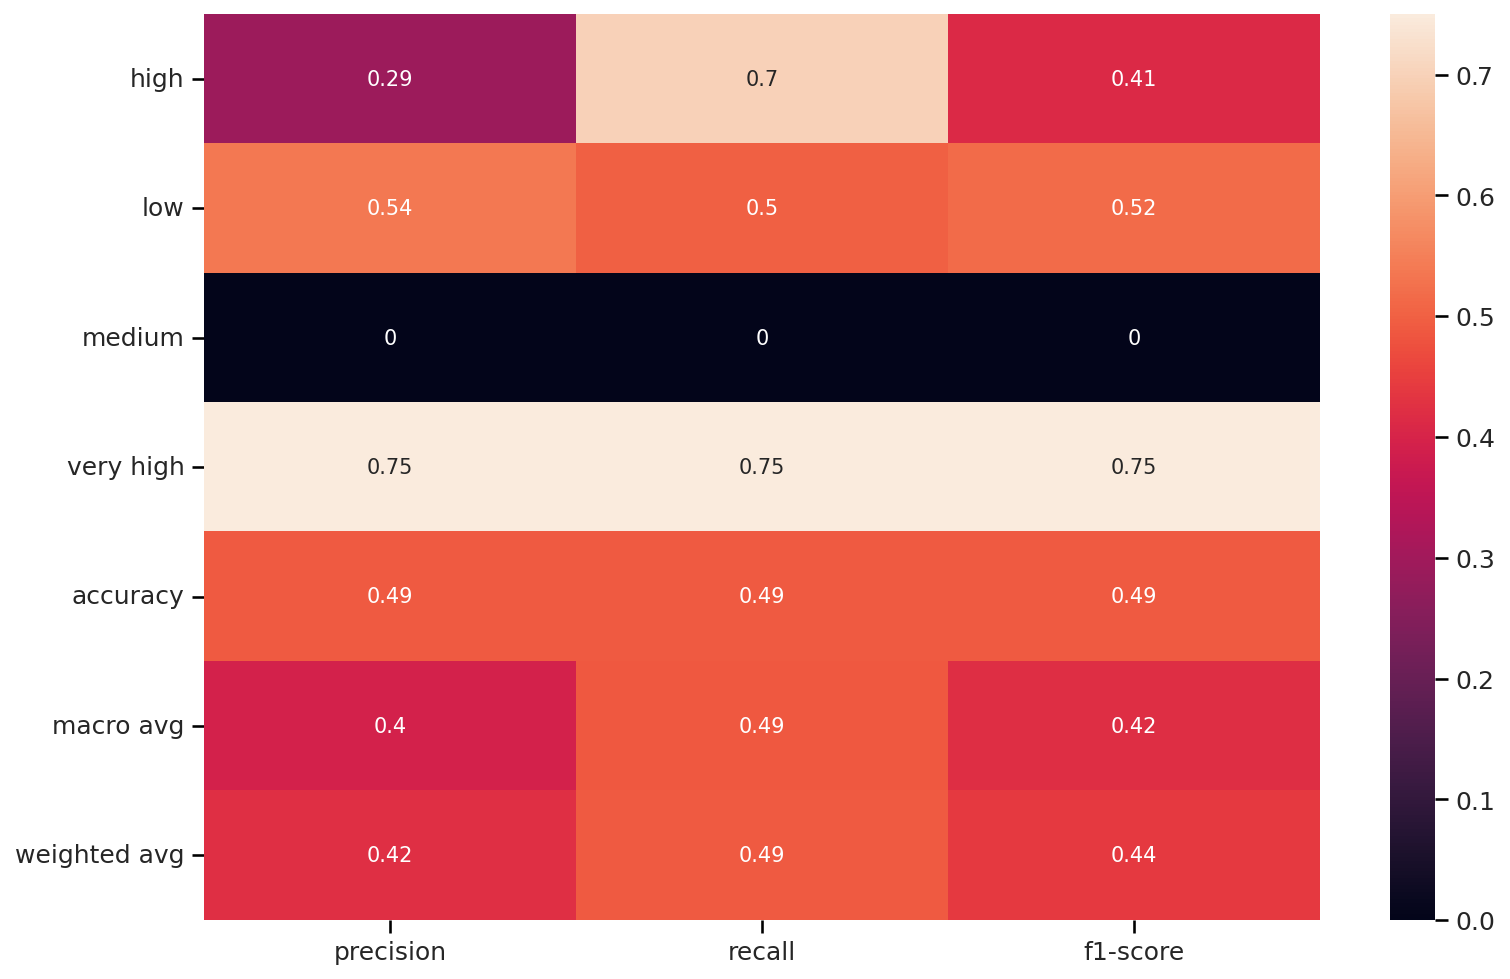

In [ ]:
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :].T, annot=True)
#plot_classification_report(classification_rep)


In [ ]:
class_labels = list(val_y['marketcap_categories'].unique())
class_labels = ['high','low','medium','very high']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


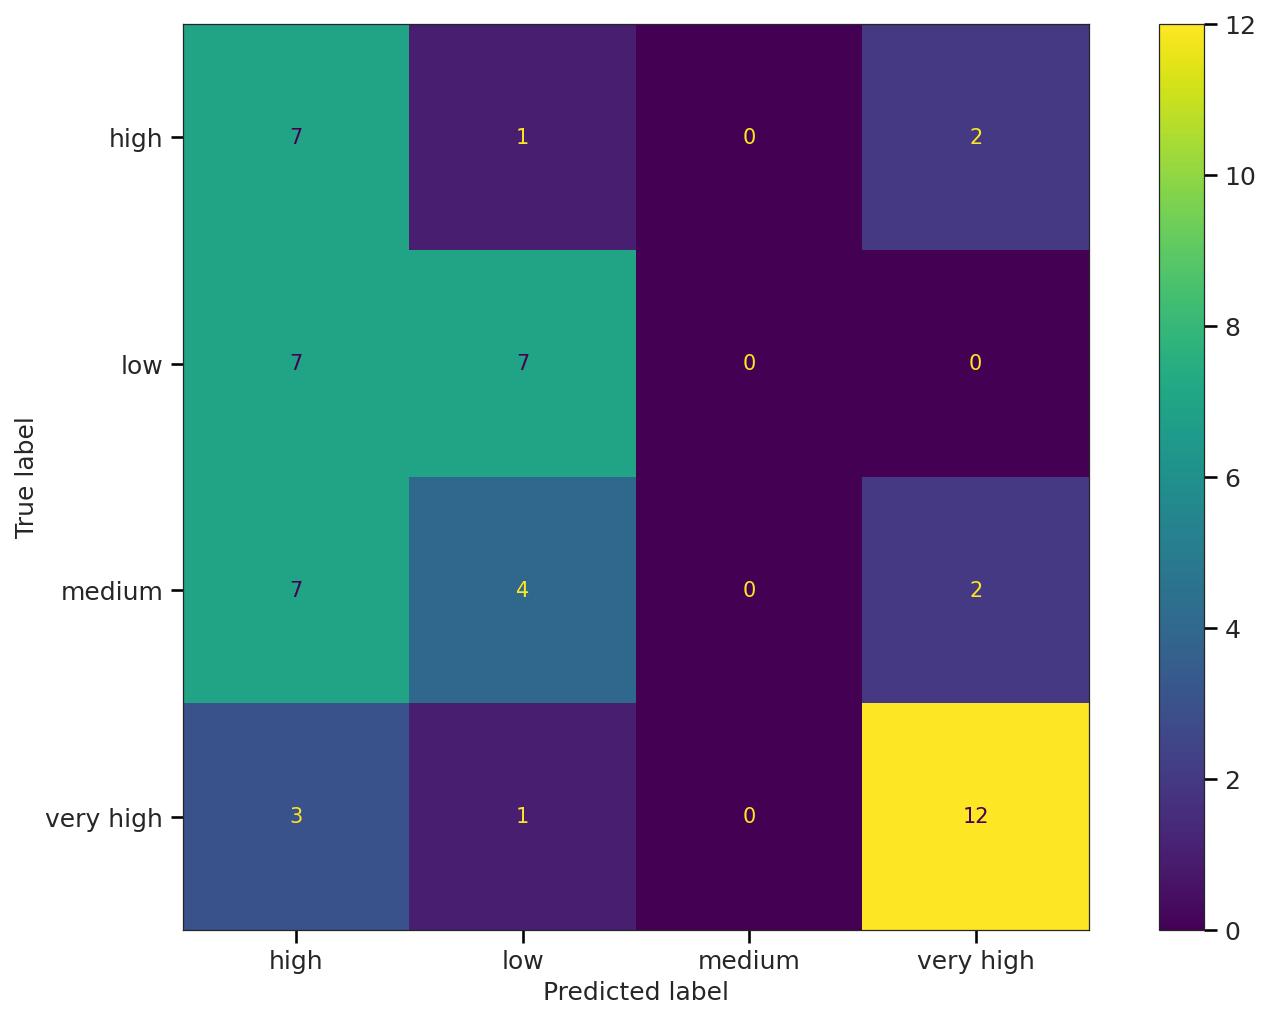

In [ ]:
plot_confusion_matrix(xgb_model, val_X, val_y) 
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

We then see that while our model only had a score of 49%, its F1 score for classifying coins that have a very high market cap was 12/16 or 75%. Our model particularly struggled with correctly classifying coins that have a medium market cap   

# Eli5 aka feature importance random forest

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
# eli5.show_weights(perm, feature_names = val_X.columns.tolist())

# Eli5 aka feature importance xgboost

In [ ]:
perm = PermutationImportance(xgb_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

# random forest feature importance

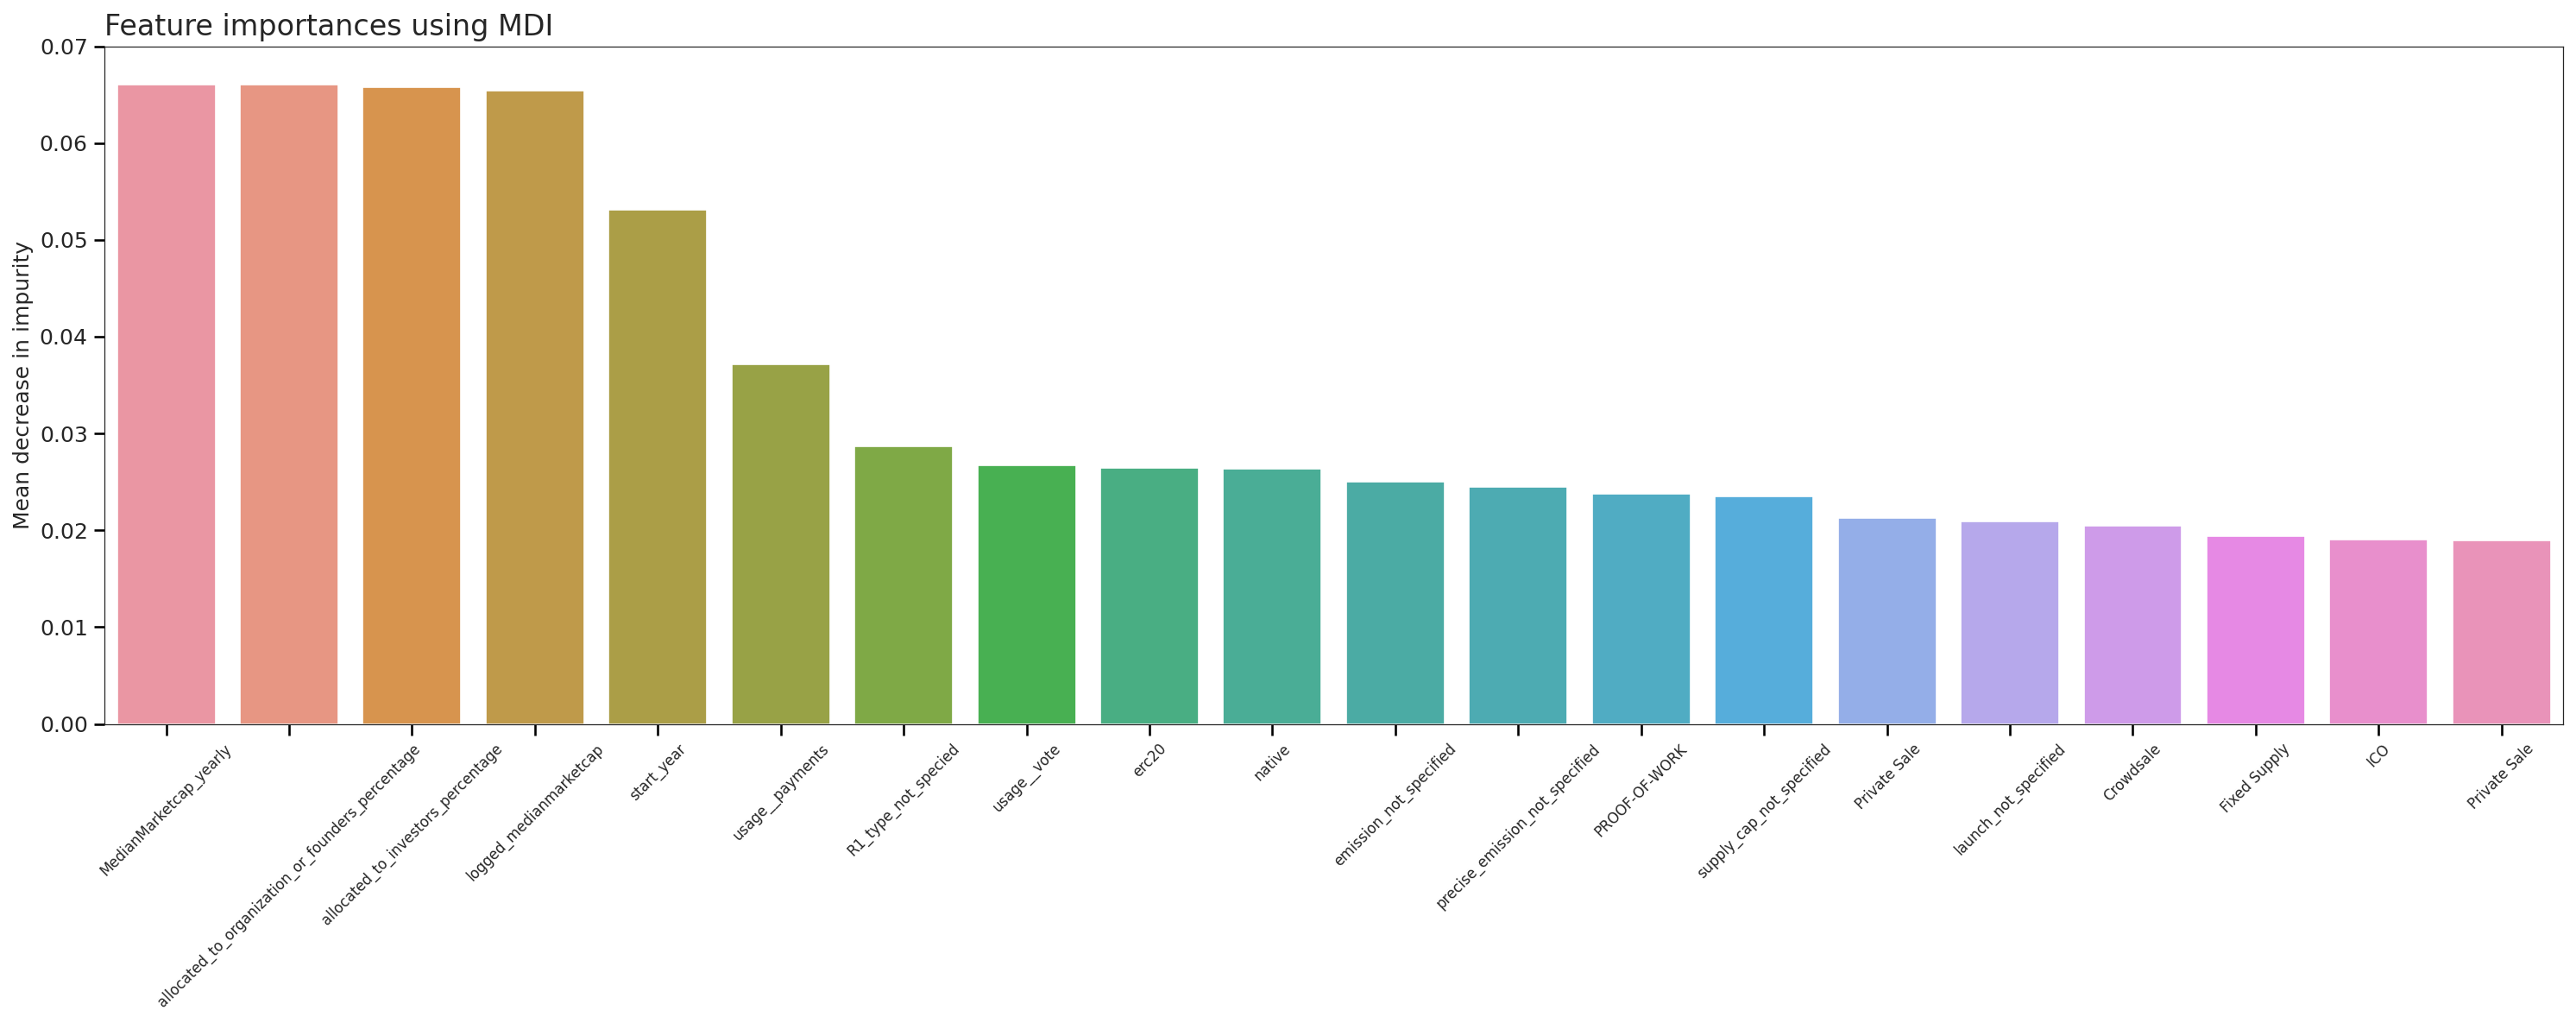

In [ ]:
feature_names = X.columns
importances = my_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in my_model.estimators_], axis=0)


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(20)

fig, ax = plt.subplots()
#forest_importances.plot.bar(ax=ax)
ax = sns.barplot(x=forest_importances.index, y=forest_importances.values)
plt.xticks(rotation=45,fontsize=8)
plt.gcf().set_size_inches(20,8)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Xgboost feature importance

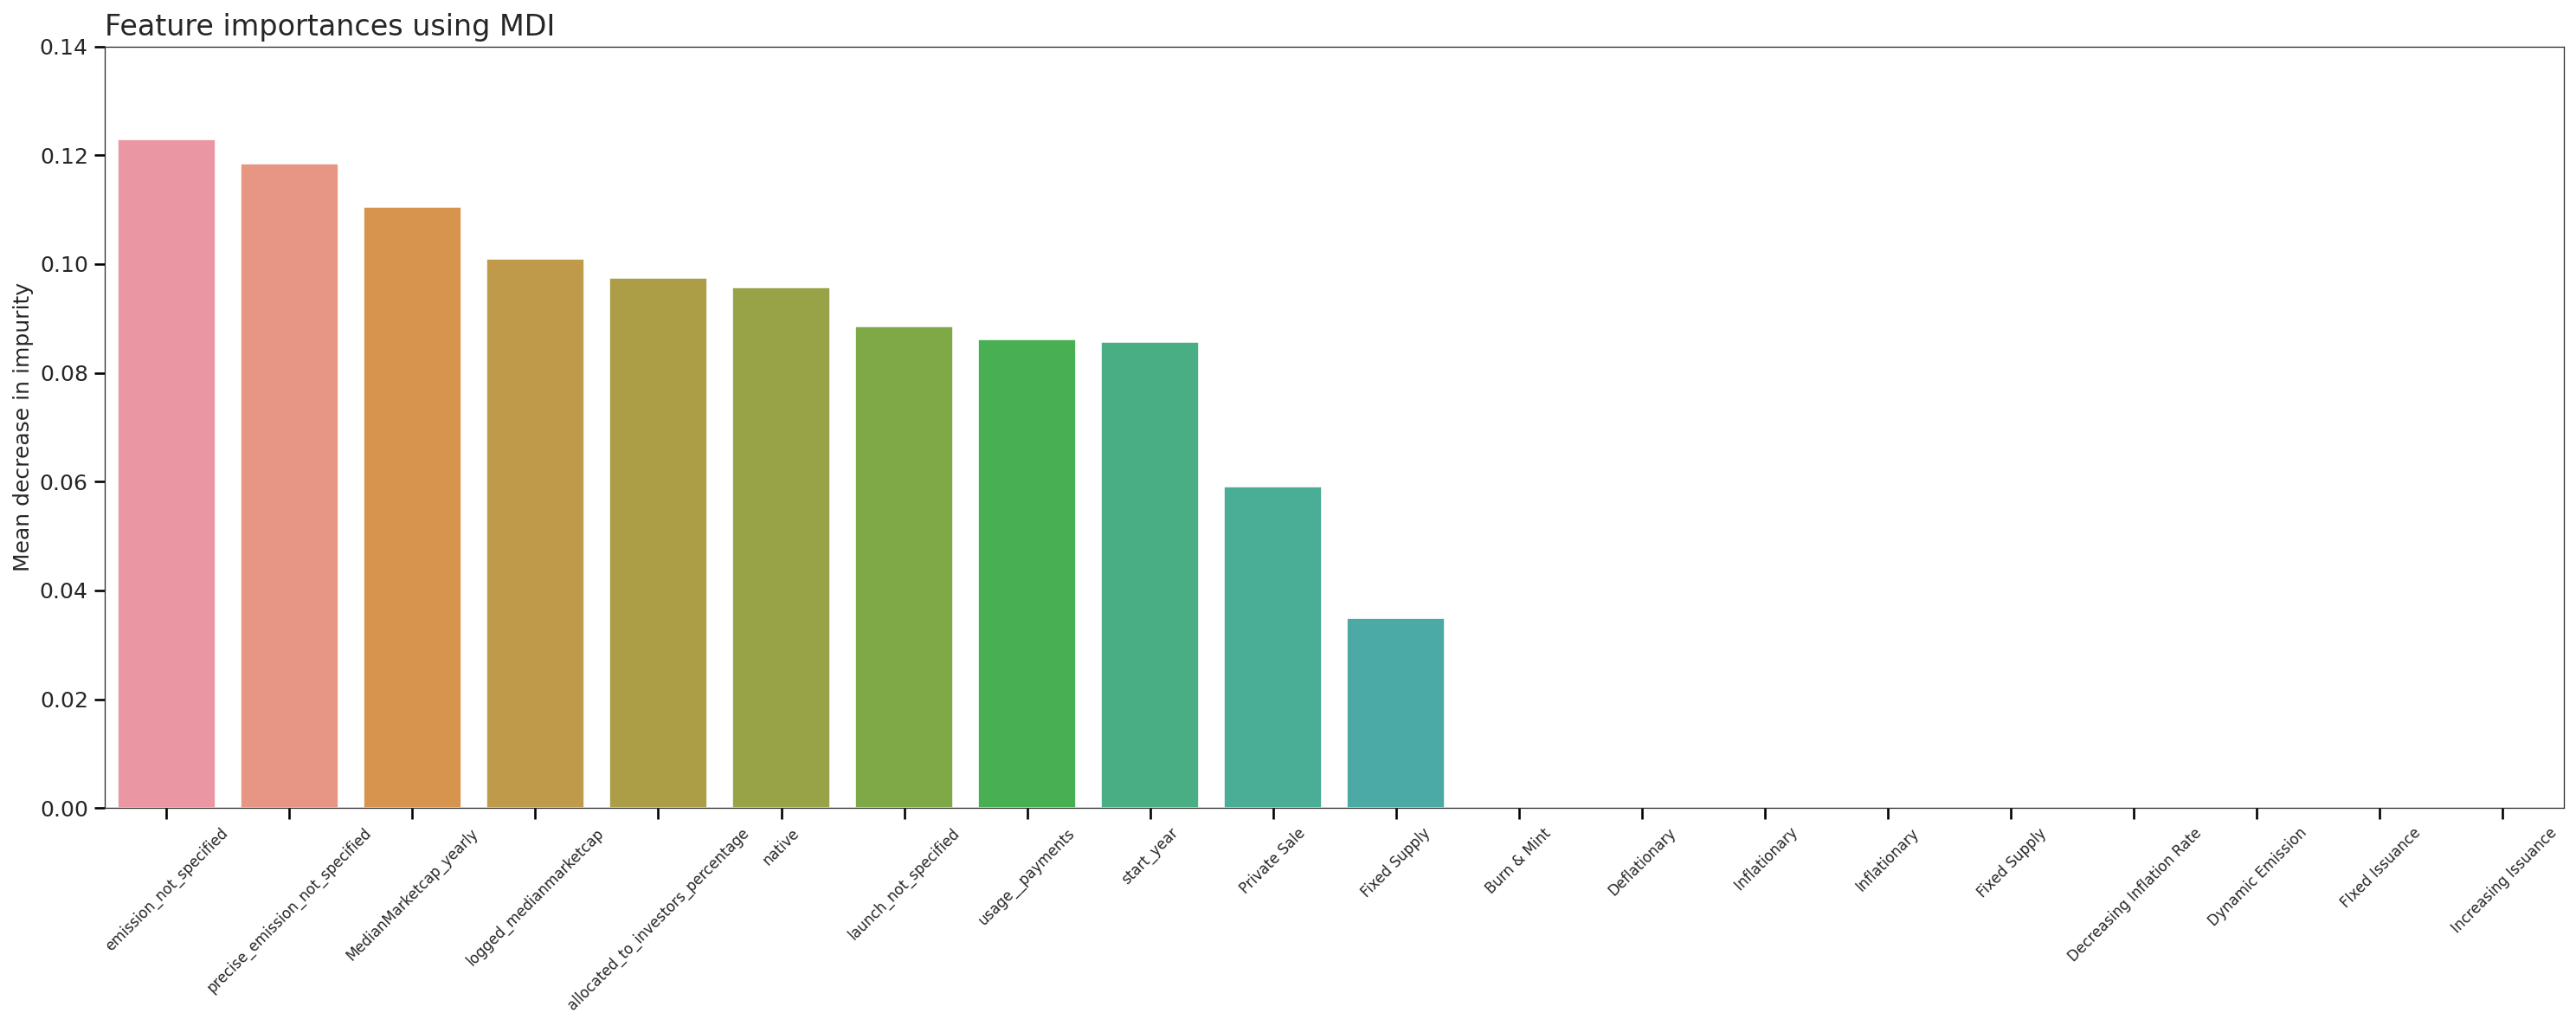

In [ ]:
feature_names = X.columns
importances = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_], axis=0)


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(20)

fig, ax = plt.subplots()
#forest_importances.plot.bar(ax=ax)
ax = sns.barplot(x=forest_importances.index, y=forest_importances.values)
plt.xticks(rotation=45,fontsize=8)
plt.gcf().set_size_inches(20,8)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Looking at the feature importance according to our XGboost model. We can see that emission type, token type, mediam market cap and usage are key features to determining a coins market cap. We can explore how each feature affects the output that our model produced by utilizing shap

# Shap values

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [ ]:
#shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_labels, feature_names = X.columns)

In [ ]:
class_labels

['high', 'low', 'medium', 'very high']

## how our model decides to classify a token with very high market cap

Shap is a library used to explain ML models. It uses a game theory approach to see which features are most important and how each feature impacts our model.

The y-axis is the features names and are arranged based on feature importance.
Our x-axis shows how a value of that feature impacts the output of our model. The color of the data point indicates the range value of a particulars samples feature.

In this plot we see how a model classifies a coin to be very high.

We see that if the median market cap of the start year of the coin is high it is usually going to have a higher market cap. If it has its own native protocol it also increased the probability. The higher the percentage that was allocated to investors also increased its probability.

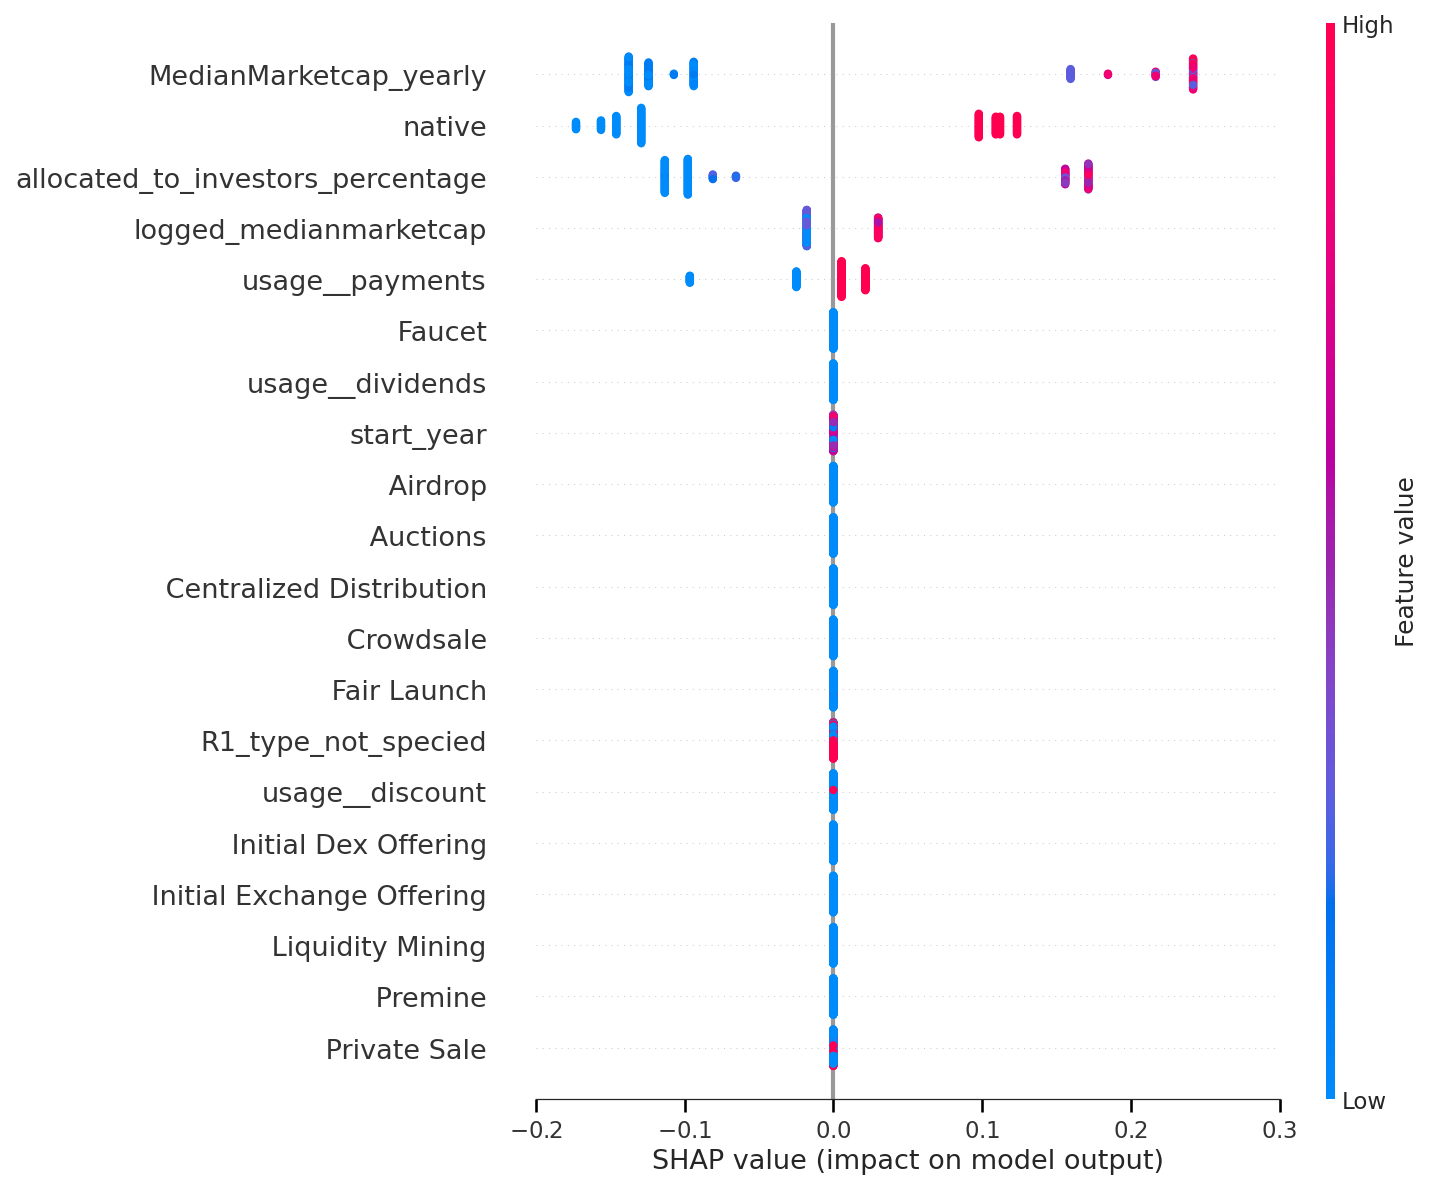

In [ ]:
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

In [ ]:
# explore more feautre interactions
# dependence plot
# shap 
# https://www.kaggle.com/code/saikiranputta/ted-eda-with-partial-dependence-plots-using-rf/notebook

In [ ]:
train_X.T

458           23   \
PROOF-OF-WORK                                     0.000000e+00  1.000000e+00   
DELEGATED PROOF-OF-STAKE                          0.000000e+00  0.000000e+00   
HYBRID POW & POS                                  0.000000e+00  0.000000e+00   
PROOF-OF-STAKE, DAG                               0.000000e+00  0.000000e+00   
DAG                                               0.000000e+00  0.000000e+00   
PROOF-OF-WORK, OTHER                              0.000000e+00  0.000000e+00   
PROOF-OF-STAKE, OTHER                             0.000000e+00  0.000000e+00   
HYBRID POW & DPOS                                 0.000000e+00  0.000000e+00   
allocated_to_investors_percentage                 0.000000e+00  0.000000e+00   
allocated_to_organization_or_founders_percentage  0.000000e+00  0.000000e+00   
erc20                                             1.000000e+00  0.000000e+00   
native                                            0.000000e+00  1.000000e+00   
omni                                              0.000000e+00  0.000000e+00   
trc20                                             0.000000e+00  0.000000e+00   
trc10                                             0.000000e+00  0.000000e+00   
bep2                                              0.000000e+00  0.000000e+00   
bep20                                             0.000000e+00  0.000000e+00   
erc777                                            0.000000e+00  0.000000e+00   
ardor                                             0.000000e+00  0.000000e+00   
spl                                               1.000000e+00  0.000000e+00   
eosio                                             0.000000e+00  0.000000e+00   
usage__payments                                   0.000000e+00  1.000000e+00   
usage__work                                       0.000000e+00  0.000000e+00   
usage__access                                     0.000000e+00  0.000000e+00   
usage__discount                                   0.000000e+00  0.000000e+00   
usage__vote                                       1.000000e+00  0.000000e+00   
usage__dividends                                  1.000000e+00  0.000000e+00   
start_year                                        2.021000e+03  2.009000e+03   
MedianMarketcap_yearly                            8.584507e+07  1.342765e+09   
logged_medianmarketcap                            1.826805e+01  2.101800e+01   
 Airdrop                                          0.000000e+00  0.000000e+00   
 Auctions                                         0.000000e+00  0.000000e+00   
 Centralized Distribution                         0.000000e+00  0.000000e+00   
 Crowdsale                                        0.000000e+00  0.000000e+00   
 Fair Launch                                      0.000000e+00  0.000000e+00   
 Faucet                                           0.000000e+00  0.000000e+00   
 Initial Dex Offering                             0.000000e+00  0.000000e+00   
 Initial Exchange Offering                        0.000000e+00  0.000000e+00   
 Liquidity Mining                                 0.000000e+00  0.000000e+00   
 Premine                                          0.000000e+00  0.000000e+00   
 Private Sale                                     0.000000e+00  0.000000e+00   
Airdrop                                           0.000000e+00  0.000000e+00   
Auctions                                          0.000000e+00  0.000000e+00   
Centralized Distribution                          0.000000e+00  0.000000e+00   
Crowdsale                                         0.000000e+00  0.000000e+00   
Fair Launch                                       0.000000e+00  0.000000e+00   
Fair Launch with Built-in Treasury                0.000000e+00  0.000000e+00   
Faucet                                            0.000000e+00  0.000000e+00   
Initial Exchange Offering                         1.000000e+00  0.000000e+00   
Instamine & Stealthmine                           0.000000e

In [ ]:
val_y.value_counts()

marketcap_categories
very high               16
low                     14
medium                  13
high                    10
dtype: int64